i imnported apple , nasdaq and sp500 from yfinance .
The main work is for apple but nasdaq and sp500 are just used here as features to study if they affect the price of apple or not

#All libraries Used

In [ ]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [ ]:
# Data processing and manipulation
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Model libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

# Metrics and evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# SHAP for model interpretability
import shap

import yfinance as yf


In [ ]:

# Define date range
start, end = "2000-01-01", "2025-03-01"

# 1) Download AAPL with all OHLCV columns
aapl = yf.download("AAPL", start=start, end=end)[["Close", "High", "Low", "Open", "Volume"]]
aapl.index.name = "Date"

# 2) Download S&P 500 close only and rename
sp500 = yf.download("^GSPC", start=start, end=end)[["Close"]].rename(columns={"Close": "SP500"})
sp500.index.name = "Date"

# 3) Download NASDAQ close only and rename
nasdaq = yf.download("^IXIC", start=start, end=end)[["Close"]].rename(columns={"Close": "NASDAQ"})
nasdaq.index.name = "Date"

# 4) Join all three on the Date index
data = aapl.join([sp500, nasdaq], how="inner")

# 5) Reset index to make Date a column again
data = data.reset_index()
data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SP500', 'NASDAQ']
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume,SP500,NASDAQ
0,2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800,1455.219971,4131.149902
1,2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600,1399.420044,3901.689941
2,2000-01-05,0.782433,0.831806,0.774910,0.780553,778321600,1402.109985,3877.540039
3,2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800,1403.449951,3727.129883
4,2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400,1441.469971,3882.620117


#Data Visualization

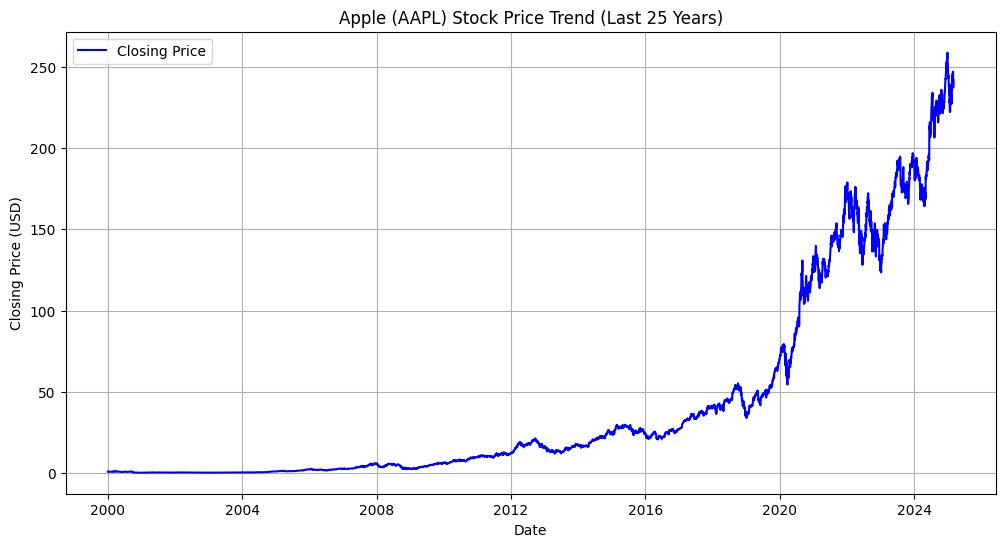

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data["Close"], label="Closing Price", color='blue')

plt.title("Apple (AAPL) Stock Price Trend (Last 25 Years)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

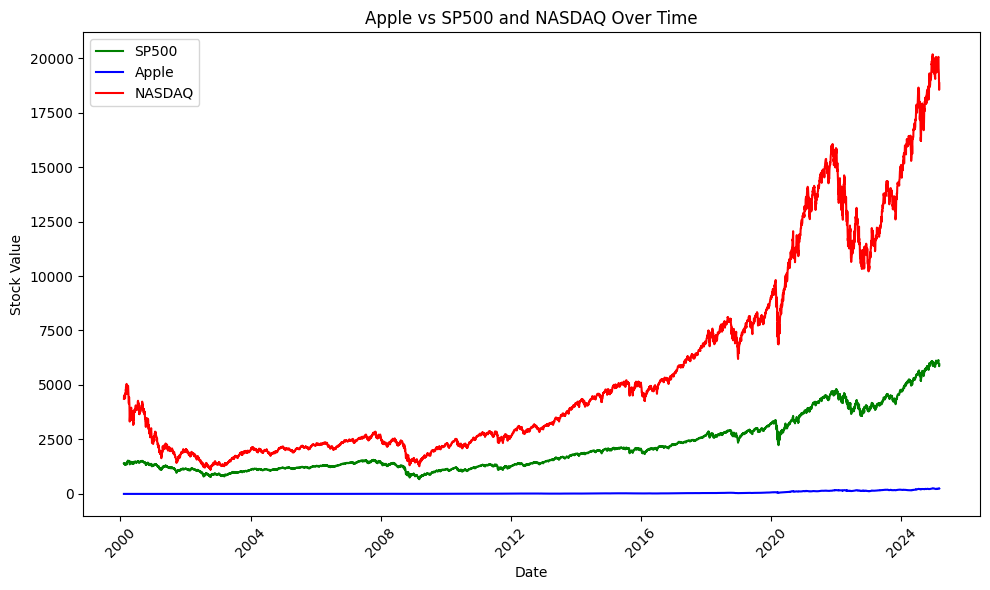

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

# Plotting Apple vs SP500
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['SP500'], label='SP500', color='green', linestyle='-')
plt.plot(data['Date'], data['Close'], label='Apple', color='blue', linestyle='-')
plt.plot(data['Date'], data['NASDAQ'], label='NASDAQ', color='red', linestyle='-')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.title('Apple vs SP500 and NASDAQ Over Time')
plt.legend()

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


🔹 Statistical Summary:
                                 Date        Close         High          Low  \
count                           6328  6328.000000  6328.000000  6328.000000   
mean   2012-07-31 08:41:34.058154240    42.449816    42.867815    41.987019   
min              2000-01-03 00:00:00     0.197414     0.198468     0.191395   
25%              2006-04-19 18:00:00     2.025826     2.055845     1.995431   
50%              2012-07-30 12:00:00    14.049674    14.187352    13.870721   
75%              2018-11-09 18:00:00    45.044333    45.379321    44.546847   
max              2025-02-28 00:00:00   258.735504   259.814335   257.347047   
std                              NaN    61.893941    62.478879    61.228232   

              Open        Volume        SP500        NASDAQ  
count  6328.000000  6.328000e+03  6328.000000   6328.000000  
mean     42.414914  3.838680e+08  2136.027604   5543.437778  
min       0.195458  2.323470e+07   676.530029   1114.109985  
25%       2.0271

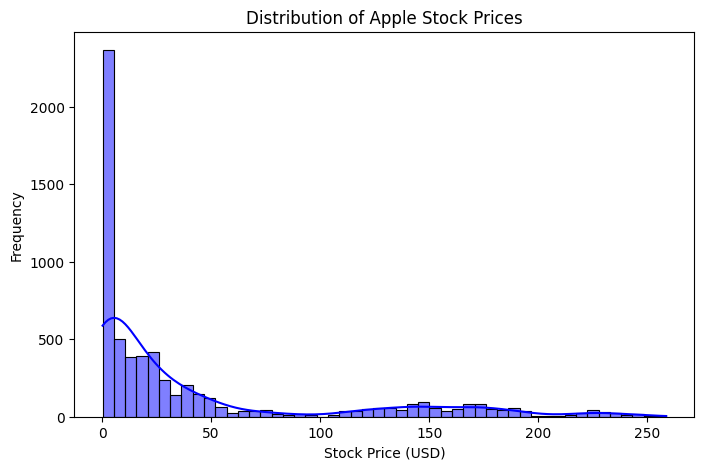

In [ ]:

print("🔹 Statistical Summary:\n", data.describe())

plt.figure(figsize=(8, 5))
sns.histplot(data["Close"], bins=50, kde=True, color="blue")
plt.title("Distribution of Apple Stock Prices")
plt.xlabel("Stock Price (USD)")
plt.ylabel("Frequency")
plt.show()

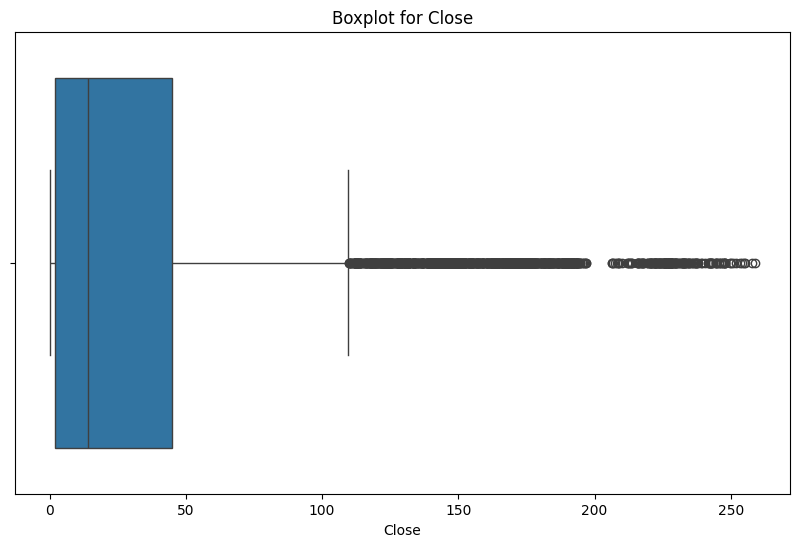

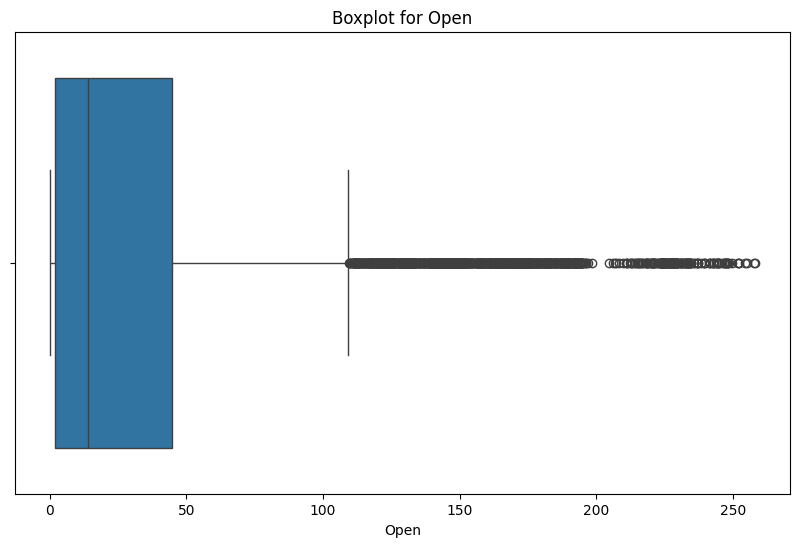

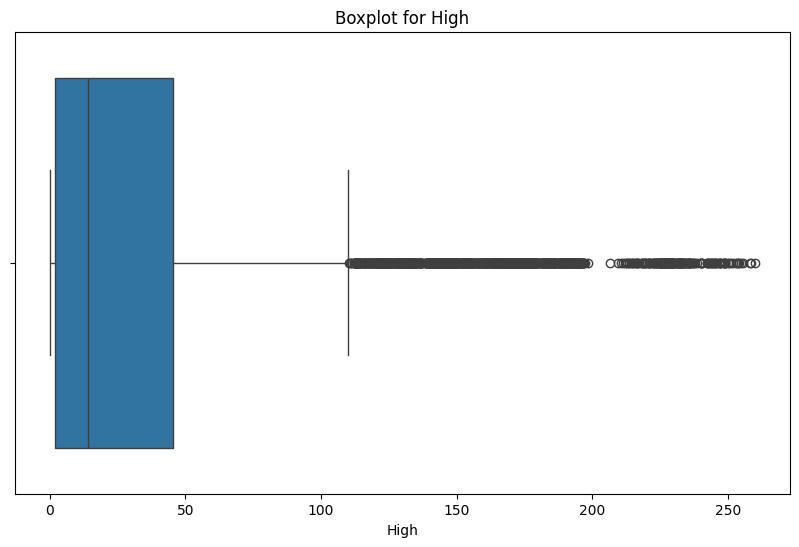

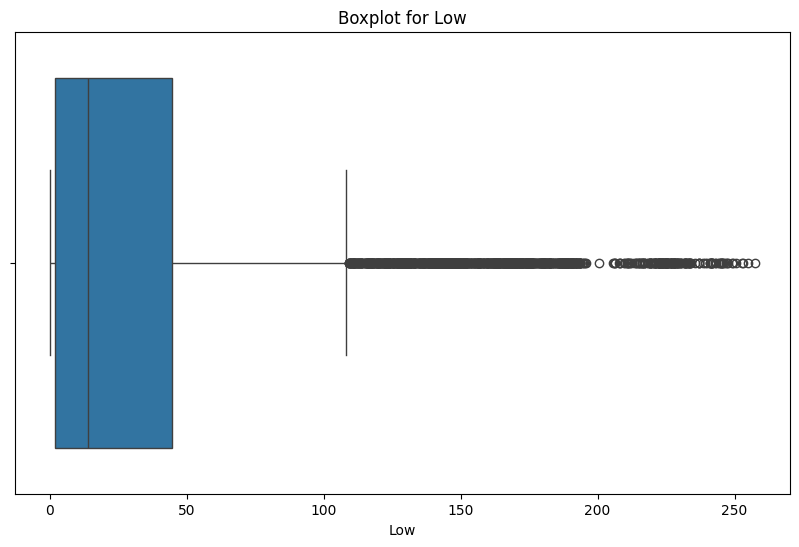

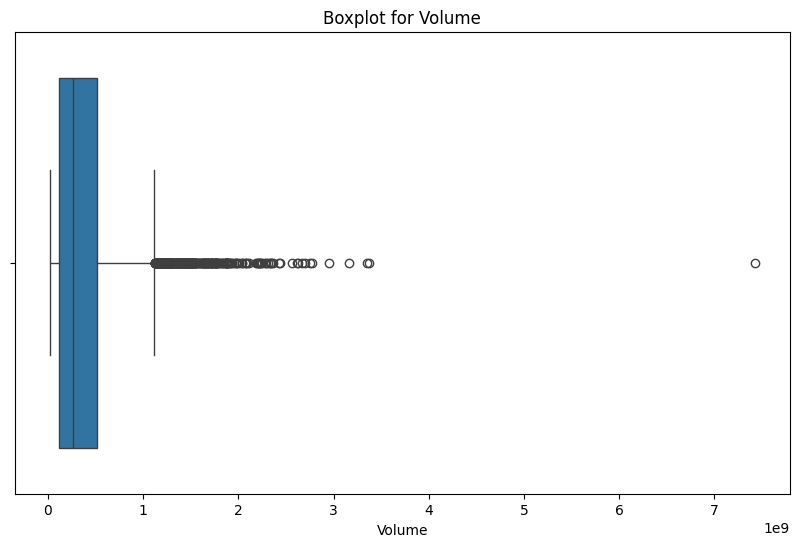

In [ ]:

features_to_check = ['Close', 'Open', 'High', 'Low', 'Volume']

# Create boxplots for each selected feature
for feature in features_to_check:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot for {feature}')
    plt.show()

# Feature Engineering

In [ ]:
# Add Lag Features (1, 5)
data['Lag1'] = data['Close'].shift(1)
data['Lag5'] = data['Close'].shift(5)


In [ ]:

data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Add Exponential Moving Average (EMA)
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()

# Add RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Add MACD
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Add Bollinger Bands
data['Upper_Band'] = data['SMA_20'] + (2 * data['Close'].rolling(window=20).std())
data['Lower_Band'] = data['SMA_20'] - (2 * data['Close'].rolling(window=20).std())

data['True_Range'] = pd.concat([data['High'] - data['Low'],
                                (data['High'] - data['Close'].shift()).abs(),
                                (data['Low'] - data['Close'].shift()).abs()], axis=1).max(axis=1)
data['ATR'] = data['True_Range'].rolling(window=14).mean()

# Add Stochastic Oscillator
data['Stochastic'] = 100 * (data['Close'] - data['Low'].rolling(window=14).min()) / (data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min())
# Top recommended transformations:
data['RSI_EMA'] = data['RSI'].ewm(span=14).mean()
data['Stochastic_SMA'] = data['Stochastic'].rolling(14).mean()
data['Market_Sync'] = (data['SP500'].pct_change() * data['NASDAQ'].pct_change()).abs()
data['Day_of_Week'] = data['Date'].dt.dayofweek  # This gives the name of the day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year



# Adding the output

In [ ]:

data['Return'] = data['Close'].pct_change()  # Calculate daily returns (percentage change)

# Calculate the sign return: +1 if the return is positive, 0 if negative
data['Sign_Return'] = data['Return'].apply(lambda x: 1 if x > 0 else 0)

# Display the first few rows of the dataframe
data.head()


,Date,Close,High,Low,Open,Volume,SP500,NASDAQ,Lag1,Lag5,...,ATR,Stochastic,RSI_EMA,Stochastic_SMA,Market_Sync,Day_of_Week,Month,Year,Return,Sign_Return
0,2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800,1455.219971,4131.149902,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,2000,NaN,0
1,2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600,1399.420044,3901.689941,0.842151,NaN,...,NaN,NaN,NaN,NaN,0.002130,1,1,2000,-0.084310,0
2,2000-01-05,0.782433,0.831806,0.774910,0.780553,778321600,1402.109985,3877.540039,0.771149,NaN,...,NaN,NaN,NaN,NaN,0.000012,2,1,2000,0.014633,1
3,2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800,1403.449951,3727.129883,0.782433,NaN,...,NaN,NaN,NaN,NaN,0.000037,3,1,2000,-0.086539,0
4,2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400,1441.469971,3882.620117,0.714723,NaN,...,NaN,NaN,NaN,NaN,0.001130,4,1,2000,0.047369,1


In [ ]:
data.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0
SP500,0
NASDAQ,0
Lag1,1
Lag5,5


In [ ]:
data.dropna(inplace=True)

# Feature Selection

#in this section , I will drop all features that are highly correlated , features that are used to calculate another features, + the ones that have low importance ( using SHAP)

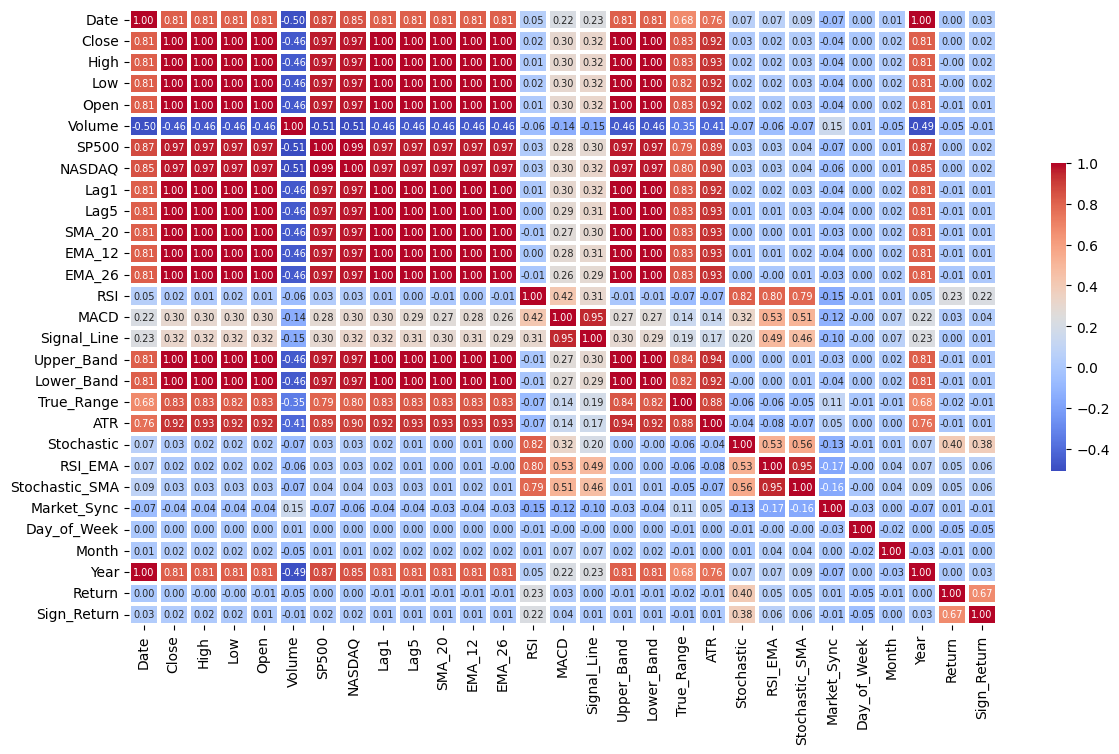

In [ ]:
plt.figure(figsize=(14,8))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 7}, linewidths=1.5, cbar_kws={'shrink': 0.5})
plt.show()

In [ ]:
data['Sign_Return'].value_counts()

,count
Sign_Return,
1,3295
0,3007


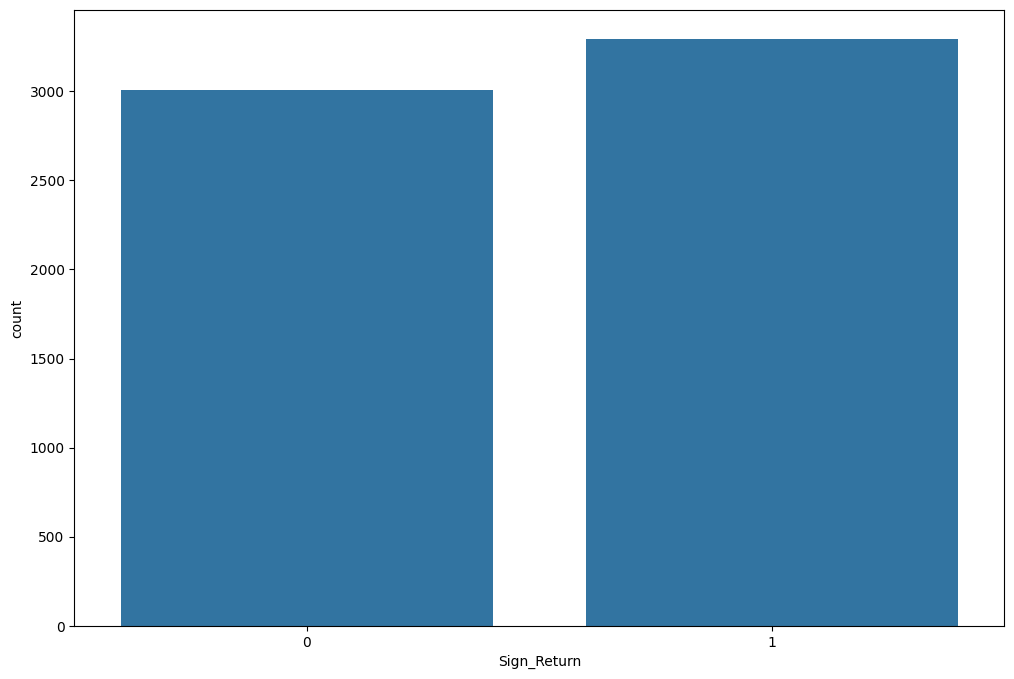

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data['Sign_Return'].value_counts())
plt.show()

**bold text**
data is slightly imbalanced , so i will not change anything ( wont affect)

# features to select and to drop

In [ ]:
import numpy as np

corr_matrix = data.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.90
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Features to potentially drop due to high correlation (> 0.90):")
print(to_drop)

Features to potentially drop due to high correlation (> 0.90):
['High', 'Low', 'Open', 'SP500', 'NASDAQ', 'Lag1', 'Lag5', 'SMA_20', 'EMA_12', 'EMA_26', 'Signal_Line', 'Upper_Band', 'Lower_Band', 'ATR', 'Stochastic_SMA', 'Year']


#Normalization

In [ ]:
# Normalize all columns except 'Date' and 'Sign_Return'
for column in data.columns:
    if column != 'Date' and column != 'Sign_Return':  # Exclude 'Date' and 'Sign_Return' from normalization
        data[column] = data[column].divide(data[column].max())


SHAP + XGBOOST , to determine the most important features and drop the unnecessary features


I WONT USE IT , I WILL DELETE IT LATER ON

# Feature Selection

In [ ]:
from sklearn.feature_selection import mutual_info_classif
cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'SP500', 'NASDAQ',
       'Lag1', 'Lag5','SMA_20', 'EMA_12',
       'EMA_26', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band',
       'True_Range', 'ATR', 'Stochastic', 'Day_of_Week', 'Month','RSI_EMA', 'Stochastic_SMA', 'Market_Sync','Year']

mi = mutual_info_classif(data[cols], data['Sign_Return'])
print(pd.DataFrame({'Feature':cols, 'MI_Score':mi}).sort_values('MI_Score', ascending=False))

           Feature  MI_Score
19      Stochastic  0.124290
12             RSI  0.028151
25            Year  0.010552
0            Close  0.010347
23  Stochastic_SMA  0.010081
5            SP500  0.006884
20     Day_of_Week  0.005455
8             Lag5  0.004540
4           Volume  0.003493
7             Lag1  0.001293
15      Upper_Band  0.000796
6           NASDAQ  0.000579
3             Open  0.000000
1             High  0.000000
9           SMA_20  0.000000
2              Low  0.000000
11          EMA_26  0.000000
10          EMA_12  0.000000
17      True_Range  0.000000
16      Lower_Band  0.000000
14     Signal_Line  0.000000
13            MACD  0.000000
21           Month  0.000000
18             ATR  0.000000
22         RSI_EMA  0.000000
24     Market_Sync  0.000000


#Stochastic , MACD, RSI, Day of Week . are the most important features
minor features : lag 1 , ATR, True Range, Volume

#Splitting Data

In [ ]:
split_date = '2021-04-01'
# after performing feature selection , these are the columns needed
columns = ['RSI','Stochastic','Lag1','Day_of_Week','Volume','MACD','Year']

In [ ]:
# Function to preprocess the data
def preprocess_data(data, split_date, columns):
    # Split the data into training and test sets based on the 'split_date'
    train_data = data[data['Date'] < split_date]
    test_data = data[data['Date'] >= split_date]

    # Prepare the features (X) and target (y)
    X_train = train_data[columns]
    y_train = train_data['Sign_Return']
    X_test = test_data[columns]
    y_test = test_data['Sign_Return']

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    return X_train_scaled, X_test_scaled, y_train, y_test



# this will also be used for gold and SP500 , I Will just define an array for gold and run the whole code without writing again the same functions

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(data,split_date,columns)


creating empty dic , for metrics

In [ ]:
# Initialize a dictionary to store metrics for each model
model_metrics = {}

#This method is called rolling cross validation
It is a special technique that is greatly used especially in TIME SERIES ANALYSIS


Rolling (or walk‑forward) cross‑validation simply means you always train your model on all the data up to a given point in time, then test it on the next slice of data, then move that cut‑off forward, retrain on everything before it, and test on the following slice. This way, the model only ever “sees” the past when making predictions on the future—just like it would in real use—and you repeat that process over and over to get an honest measure of how well it generalizes over time.

In [ ]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, n_splits=10):
    # Initialize TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize dictionary to store metrics
    model_metrics = {
        model_name: {
            'Final Train Accuracy': None,
            'Final Test Accuracy': None,
            'Train Precision': None,
            'Test Precision': None,
            'Train Recall': None,
            'Test Recall': None,
            'Confusion Matrix': None,
            'Train Accuracy': [],
            'Test Accuracy': []
        }
    }

    # Apply TimeSeriesSplit and train the model
    for fold, (train_index, test_index) in enumerate(tscv.split(X_train), 1):
        # Split the training data into training and validation sets for each fold
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model on the training fold
        model.fit(X_fold_train, y_fold_train)

        # Make predictions on the test fold
        y_test_pred = model.predict(X_fold_test)

        # Compute the metrics for each fold
        test_accuracy = accuracy_score(y_fold_test, y_test_pred)
        precision = precision_score(y_fold_test, y_test_pred)
        recall = recall_score(y_fold_test, y_test_pred)
        f1 = f1_score(y_fold_test, y_test_pred)
        cm = confusion_matrix(y_fold_test, y_test_pred)

        # Store the metrics for each fold
        model_metrics[model_name]['Train Accuracy'].append(test_accuracy)
        model_metrics[model_name]['Test Accuracy'].append(test_accuracy)

        # Print the accuracies for each fold (optional)
        print(f"Fold {fold}: Training Accuracy = {test_accuracy:.4f}")
        print(f"Fold {fold}: Testing Accuracy = {test_accuracy:.4f}")

    # Train the final model on the full training data
    model.fit(X_train, y_train)

    # Final predictions on the test data
    y_test_pred = model.predict(X_test)
    test_accuracy_final = accuracy_score(y_test, y_test_pred)
    train_accuracy_final = accuracy_score(y_train, model.predict(X_train))

    # Store final accuracy
    model_metrics[model_name]['Final Train Accuracy'] = train_accuracy_final
    model_metrics[model_name]['Final Test Accuracy'] = test_accuracy_final

    # Compute Precision, Recall for the final test data
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    TPR = recall  # TPR is the same as recall
    cm = confusion_matrix(y_test, y_test_pred)
    FPR = cm[0][1] / (cm[0][0] + cm[0][1])  # False Positive Rate

    # Store the metrics for the final model
    model_metrics[model_name]['Precision'] = precision
    model_metrics[model_name]['Recall'] = recall
    model_metrics[model_name]['TPR'] = TPR
    model_metrics[model_name]['FPR'] = FPR
    model_metrics[model_name]['Confusion Matrix'] = cm

    # Print final metrics (optional)
    print(f"Final Model Test Accuracy: {test_accuracy_final:.4f}")
    print(f"Final Model Training Accuracy: {train_accuracy_final:.4f}")
    print(f"Final Model Precision: {precision:.4f}")
    print(f"Final Model Recall: {recall:.4f}")
    print(f"Final Model F1 Score: {f1_score(y_test, y_test_pred):.4f}")
    print(f"Final Model Confusion Matrix:")
    print(cm)

    # Return the model_metrics dictionary
    return model_metrics


#XGB

In [ ]:
# Initialize the model
model_xgb = XGBClassifier(
    max_depth=3,
    min_child_weight=10,
    n_estimators=420,  # Initial high number of estimators to allow early stopping
    learning_rate=0.01,
    reg_lambda=7,
    reg_alpha=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1
)

In [ ]:

# Train and evaluate the model
xgb_metrics = train_and_evaluate_model(model_xgb, X_train_scaled, X_test_scaled,
                                      y_train, y_test, 'XGBoost')

# Access the metrics for XGBoost
print("\nXGBoost Metrics:")
print(f"Accuracy: {xgb_metrics['XGBoost']['Final Test Accuracy']}, Precision: {xgb_metrics['XGBoost']['Precision']}, Recall: {xgb_metrics['XGBoost']['Recall']}")

# Visualizing the Confusion Matrix
cm_xgb = xgb_metrics['XGBoost']['Confusion Matrix']




Fold 1: Training Accuracy = 0.6791
Fold 1: Testing Accuracy = 0.6791
Fold 2: Training Accuracy = 0.6356
Fold 2: Testing Accuracy = 0.6356
Fold 3: Training Accuracy = 0.6977
Fold 3: Testing Accuracy = 0.6977
Fold 4: Training Accuracy = 0.6957
Fold 4: Testing Accuracy = 0.6957
Fold 5: Training Accuracy = 0.7081
Fold 5: Testing Accuracy = 0.7081
Fold 6: Training Accuracy = 0.7122
Fold 6: Testing Accuracy = 0.7122
Fold 7: Training Accuracy = 0.6791
Fold 7: Testing Accuracy = 0.6791
Fold 8: Training Accuracy = 0.6791
Fold 8: Testing Accuracy = 0.6791
Fold 9: Training Accuracy = 0.7019
Fold 9: Testing Accuracy = 0.7019
Fold 10: Training Accuracy = 0.6812
Fold 10: Testing Accuracy = 0.6812
Final Model Test Accuracy: 0.6907
Final Model Training Accuracy: 0.6992
Final Model Precision: 0.7251
Final Model Recall: 0.6781
Final Model F1 Score: 0.7008
Final Model Confusion Matrix:
[[323 135]
 [169 356]]

XGBoost Metrics:
Accuracy: 0.6907426246185148, Precision: 0.725050916496945, Recall: 0.678095238

#CM for XGB

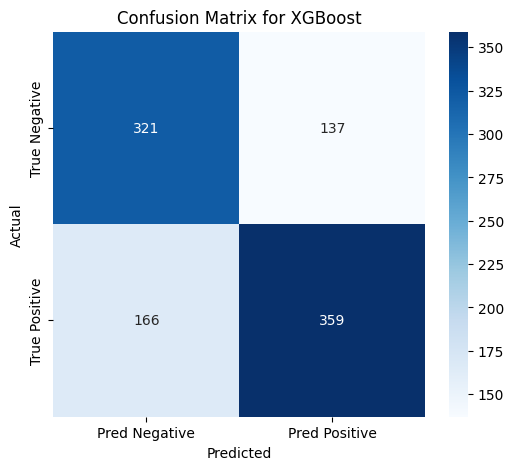

In [ ]:
cm_xgb = xgb_metrics['XGBoost']['Confusion Matrix']

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Random Forest

In [ ]:
# Initialize the Random Forest model
model_rf = RandomForestClassifier(
    n_estimators=450,            # Increase number of trees
    max_depth=3,                 # Limit tree depth
    min_samples_split=9,         # Minimum samples to split a node
    min_samples_leaf=11,
    class_weight='balanced'
)

Fold 1: Training Accuracy = 0.6563
Fold 1: Testing Accuracy = 0.6563
Fold 2: Training Accuracy = 0.6046
Fold 2: Testing Accuracy = 0.6046
Fold 3: Training Accuracy = 0.6460
Fold 3: Testing Accuracy = 0.6460
Fold 4: Training Accuracy = 0.6687
Fold 4: Testing Accuracy = 0.6687
Fold 5: Training Accuracy = 0.6749
Fold 5: Testing Accuracy = 0.6749
Fold 6: Training Accuracy = 0.6812
Fold 6: Testing Accuracy = 0.6812
Fold 7: Training Accuracy = 0.6522
Fold 7: Testing Accuracy = 0.6522
Fold 8: Training Accuracy = 0.6667
Fold 8: Testing Accuracy = 0.6667
Fold 9: Training Accuracy = 0.6315
Fold 9: Testing Accuracy = 0.6315
Fold 10: Training Accuracy = 0.6667
Fold 10: Testing Accuracy = 0.6667
Final Model Test Accuracy: 0.6338
Final Model Training Accuracy: 0.6599
Final Model Precision: 0.8340
Final Model Recall: 0.3924
Final Model F1 Score: 0.5337
Final Model Confusion Matrix:
[[417  41]
 [319 206]]

Random Forest Metrics:
Accuracy: 0.6337741607324516, Precision: 0.8340080971659919, Recall: 0.39

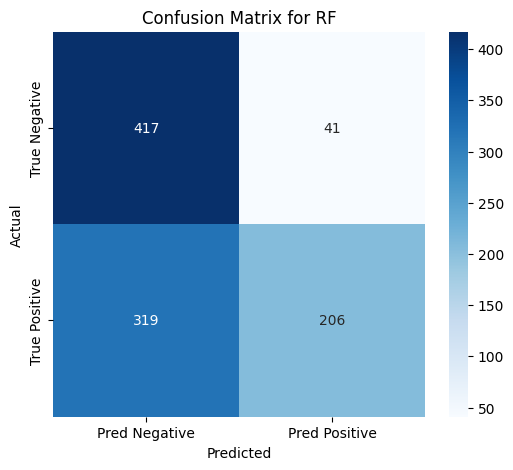

In [ ]:


# Train and evaluate the model for Random Forest
rf_metrics = train_and_evaluate_model(model_rf, X_train_scaled, X_test_scaled, y_train, y_test, 'RF')

# Access the metrics for Random Forest
print("\nRandom Forest Metrics:")
print(f"Accuracy: {rf_metrics['RF']['Final Test Accuracy']}, Precision: {rf_metrics['RF']['Precision']}, Recall: {rf_metrics['RF']['Recall']}")

# Visualizing the Confusion Matrix for Random Forest
cm_rf = rf_metrics['RF']['Confusion Matrix']


# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for RF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Naive Bayes

In [ ]:
model_nb = GaussianNB(priors=None, var_smoothing=1e-1)

Fold 1: Training Accuracy = 0.6253
Fold 1: Testing Accuracy = 0.6253
Fold 2: Training Accuracy = 0.5673
Fold 2: Testing Accuracy = 0.5673
Fold 3: Training Accuracy = 0.6128
Fold 3: Testing Accuracy = 0.6128
Fold 4: Training Accuracy = 0.6377
Fold 4: Testing Accuracy = 0.6377
Fold 5: Training Accuracy = 0.6108
Fold 5: Testing Accuracy = 0.6108
Fold 6: Training Accuracy = 0.6356
Fold 6: Testing Accuracy = 0.6356
Fold 7: Training Accuracy = 0.6480
Fold 7: Testing Accuracy = 0.6480
Fold 8: Training Accuracy = 0.6108
Fold 8: Testing Accuracy = 0.6108
Fold 9: Training Accuracy = 0.6108
Fold 9: Testing Accuracy = 0.6108
Fold 10: Training Accuracy = 0.6004
Fold 10: Testing Accuracy = 0.6004
Final Model Test Accuracy: 0.5910
Final Model Training Accuracy: 0.6206
Final Model Precision: 0.6194
Final Model Recall: 0.6076
Final Model F1 Score: 0.6135
Final Model Confusion Matrix:
[[262 196]
 [206 319]]

Naive Bayes Metrics:
Accuracy: 0.5910478128179044, Precision: 0.6194174757281553, Recall: 0.6076

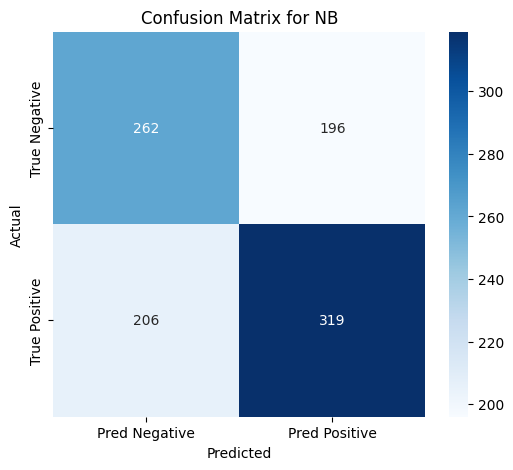

In [ ]:


# Train and evaluate the Naive Bayes model
nb_metrics = train_and_evaluate_model(model_nb, X_train_scaled, X_test_scaled, y_train, y_test, 'NB')

# Access the metrics for Naive Bayes
print("\nNaive Bayes Metrics:")
print(f"Accuracy: {nb_metrics['NB']['Final Test Accuracy']}, Precision: {nb_metrics['NB']['Precision']}, Recall: {nb_metrics['NB']['Recall']}")

# Visualizing the Confusion Matrix for Naive Bayes
cm_nb = nb_metrics['NB']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for NB')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#SVM

In [ ]:
# Initialize the SVM model with the specified hyperparameters
model_svm = SVC(kernel='poly', gamma=0.05, degree=2, coef0=0.1,C=1,probability=True,class_weight='balanced')

Fold 1: Training Accuracy = 0.6501
Fold 1: Testing Accuracy = 0.6501
Fold 2: Training Accuracy = 0.6273
Fold 2: Testing Accuracy = 0.6273
Fold 3: Training Accuracy = 0.6190
Fold 3: Testing Accuracy = 0.6190
Fold 4: Training Accuracy = 0.6480
Fold 4: Testing Accuracy = 0.6480
Fold 5: Training Accuracy = 0.6584
Fold 5: Testing Accuracy = 0.6584
Fold 6: Training Accuracy = 0.6708
Fold 6: Testing Accuracy = 0.6708
Fold 7: Training Accuracy = 0.6605
Fold 7: Testing Accuracy = 0.6605
Fold 8: Training Accuracy = 0.6294
Fold 8: Testing Accuracy = 0.6294
Fold 9: Training Accuracy = 0.6584
Fold 9: Testing Accuracy = 0.6584
Fold 10: Training Accuracy = 0.6542
Fold 10: Testing Accuracy = 0.6542
Final Model Test Accuracy: 0.6399
Final Model Training Accuracy: 0.6558
Final Model Precision: 0.6680
Final Model Recall: 0.6476
Final Model F1 Score: 0.6576
Final Model Confusion Matrix:
[[289 169]
 [185 340]]

SVM Metrics:
Accuracy: 0.6398779247202442, Precision: 0.6679764243614931, Recall: 0.647619047619

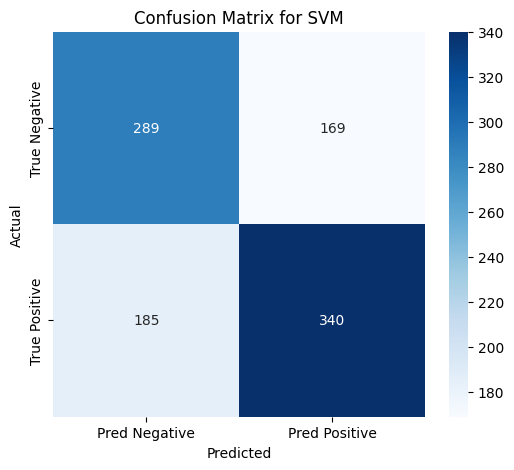

In [ ]:


# Train and evaluate the SVM model
svm_metrics = train_and_evaluate_model(model_svm, X_train_scaled, X_test_scaled, y_train, y_test, 'SVM')

# Access the metrics for SVM
print("\nSVM Metrics:")
print(f"Accuracy: {svm_metrics['SVM']['Final Test Accuracy']}, Precision: {svm_metrics['SVM']['Precision']}, Recall: {svm_metrics['SVM']['Recall']}")

# Visualizing the Confusion Matrix for SVM
cm_svm = svm_metrics['SVM']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
print(columns)

['RSI', 'Stochastic', 'Lag1', 'Day_of_Week', 'Volume', 'MACD', 'Year']


In [ ]:
col_LSTM  = [ 'Volume','Lag1','SMA_20','RSI', 'MACD','Stochastic', 'Day_of_Week','Stochastic_SMA','Year']

#CM FOR LSTM

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Ensures that CUDA operations are deterministic
np.random.seed(seed)
random.seed(seed)
X_train_scaled_LSTM, X_test_scaled_LSTM, y_train_LSTM, y_test_LSTM = preprocess_data(data, split_date, col_LSTM)
X_train = torch.tensor(X_train_scaled_LSTM, dtype=torch.float32)
y_train = torch.tensor(y_train_LSTM.values, dtype=torch.float32).unsqueeze(1)  # (N, 1)
X_test = torch.tensor(X_test_scaled_LSTM, dtype=torch.float32)
y_test = torch.tensor(y_test_LSTM.values, dtype=torch.float32).unsqueeze(1)

# Define the model with LSTM layer
class BinaryLSTMNet(nn.Module):
    def __init__(self, in_features, h1=264, h2=132, lstm_hidden_size=64, num_lstm_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(in_features, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, 1)  # single logit

        # Manually initialize the weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        # Pass through LSTM layer
        x, _ = self.lstm(x)  # Get the output of all timesteps

        # Feed through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)  # raw logit
        return x

# Initialize the model
model = BinaryLSTMNet(in_features=X_train.shape[1])

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 350
train_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()

    logits = model(X_train)  # raw logits (no sigmoid)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0 or epoch == 1:
        with torch.no_grad():
            model.eval()
            test_logits = model(X_test)
            test_probs = torch.sigmoid(test_logits)
            test_pred = (test_probs >= 0.5).float()

        acc = accuracy_score(y_test, test_pred)
        val_accuracies.append(acc)
        print(f"Epoch {epoch:3d} — loss: {loss.item():.4f}  test‑acc: {acc:.4f}")

# Final evaluation on the test set
with torch.no_grad():
    model.eval()
    logits = model(X_test)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()

# Test set results
test_acc_LSTM = accuracy_score(y_test, preds)
prec_LSTM = precision_score(y_test, preds, zero_division=0)
rec = recall_score(y_test, preds, zero_division=0)
cm = confusion_matrix(y_test, preds)

# Training set results
with torch.no_grad():
    model.eval()
    train_logits = model(X_train)
    train_probs = torch.sigmoid(train_logits)
    train_pred = (train_probs >= 0.5).float()

train_acc_LSTM = accuracy_score(y_train, train_pred)

# Output final results
print("\nFinal Test Results:")
print(f"Accuracy : {test_acc_LSTM:.4f}")
print(f"Precision: {prec_LSTM:.4f}")
print(f"Recall   : {rec:.4f}")
print("Confusion Matrix for AAPL:")
print(cm)

# Final Training Accuracy
print(f"Final Training Accuracy: {train_acc_LSTM:.4f}")

Epoch   1 — loss: 0.6938  test‑acc: 0.4659
Epoch  10 — loss: 0.6923  test‑acc: 0.5341
Epoch  20 — loss: 0.6919  test‑acc: 0.5341
Epoch  30 — loss: 0.6915  test‑acc: 0.5341
Epoch  40 — loss: 0.6912  test‑acc: 0.5341
Epoch  50 — loss: 0.6909  test‑acc: 0.5239
Epoch  60 — loss: 0.6905  test‑acc: 0.5117
Epoch  70 — loss: 0.6902  test‑acc: 0.5209
Epoch  80 — loss: 0.6897  test‑acc: 0.5168
Epoch  90 — loss: 0.6891  test‑acc: 0.5188
Epoch 100 — loss: 0.6882  test‑acc: 0.5158
Epoch 110 — loss: 0.6870  test‑acc: 0.5127
Epoch 120 — loss: 0.6852  test‑acc: 0.5076
Epoch 130 — loss: 0.6824  test‑acc: 0.4964
Epoch 140 — loss: 0.6779  test‑acc: 0.5219
Epoch 150 — loss: 0.6705  test‑acc: 0.5341
Epoch 160 — loss: 0.6580  test‑acc: 0.5585
Epoch 170 — loss: 0.6358  test‑acc: 0.5961
Epoch 180 — loss: 0.5959  test‑acc: 0.6317
Epoch 190 — loss: 0.5314  test‑acc: 0.6551
Epoch 200 — loss: 0.4547  test‑acc: 0.7060
Epoch 210 — loss: 0.3773  test‑acc: 0.7660
Epoch 220 — loss: 0.3159  test‑acc: 0.7996
Epoch 230 —

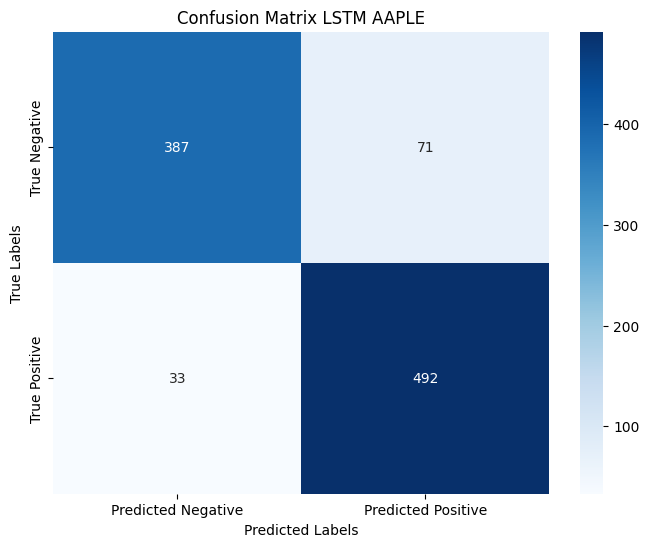

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title("Confusion Matrix LSTM AAPLE")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

P&L and Backtesting for the 4 models

In [ ]:

data['Date'] = pd.to_datetime(data['Date'])  # Make sure 'Date' is in datetime format

# Filter the data for the specific date range
start_date = '2021-03-01'
end_date = '2025-03-01'

filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Calculate the buy-and-hold return
bnh_return = (filtered_data['Close'].iloc[-1] / filtered_data['Close'].iloc[0]) - 1

# Convert to percentage
bnh_return_percentage = bnh_return * 100

print(f"Buy & Hold Return from {start_date} to {end_date}: {bnh_return_percentage:.2f}%")


Buy & Hold Return from 2021-03-01 to 2025-03-01: 93.46%


In [ ]:
print(f"First Closing Price on 2021-01-01: {filtered_data['Close'].iloc[0]}")
print(f"Last Closing Price on 2025-03-01: {filtered_data['Close'].iloc[-1]}")


First Closing Price on 2021-01-01: 125.0093765258789
Last Closing Price on 2025-03-01: 241.83999633789062


In [ ]:
# --- Preprocessing function ---
def preprocess_data_apple(data, split_date, columns):
    train_data = data[data['Date'] < split_date]
    test_data = data[data['Date'] >= split_date].copy()

    X_train = train_data[columns]
    y_train = train_data['Sign_Return']
    X_test = test_data[columns]
    y_test = test_data['Sign_Return']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, test_data

# --- Preprocess the data ---
X_train_scaled_apple, X_test_scaled_apple, y_train_apple, y_test_apple, test_df = preprocess_data_apple(data, split_date, columns)

# --- Define your models dictionary ---
models = {
    'XGBoost': model_xgb,
    'RandomForest': model_rf,
    'NaiveBayes': model_nb,
    'SVM': model_svm
}

# --- Store results ---
results = {}

# --- Backtest each classical model ---
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    model.fit(X_train_scaled_apple, y_train_apple)

    try:
        y_proba = model.predict_proba(X_test_scaled_apple)[:, 1]
    except:
        y_proba = model.predict(X_test_scaled_apple)

    threshold = 0.4
    y_pred = (y_proba >= threshold).astype(int)

    test_df_copy = test_df.copy()
    test_df_copy['buy'] = y_pred
    test_df_copy['model_return'] = test_df_copy['buy'].shift(1) * test_df_copy['Return']

    total_return = (1 + test_df_copy['model_return'].dropna()).prod() - 1
    results[name] = round(total_return * 100, 2)

# --- Add LSTM to backtest ---

with torch.no_grad():
    # Get the LSTM model:
    lstm_model = models.get('LSTM')  # Assuming 'LSTM' is added to your models dict
    if lstm_model:
        lstm_model.eval()
        lstm_logits = lstm_model(torch.tensor(X_test_scaled_apple, dtype=torch.float32))
        lstm_probs = torch.sigmoid(lstm_logits)
        lstm_preds = (lstm_probs >= 0.5).float().cpu().numpy().flatten()
    else:
        print("LSTM model not found in 'models' dictionary.")

test_df_lstm = test_df.copy()
test_df_lstm['buy'] = lstm_preds
test_df_lstm['model_return'] = test_df_lstm['buy'].shift(1) * test_df_lstm['Return']
total_return_lstm = (1 + test_df_lstm['model_return'].dropna()).prod() - 1
results['LSTM'] = round(total_return_lstm * 100, 2)

# --- Show all results ---
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Model Total Return (%)'])
results_df = results_df.sort_values('Model Total Return (%)', ascending=False)
print("\nFinal Model Returns Comparison:")
print(results_df)



Evaluating XGBoost...

Evaluating RandomForest...

Evaluating NaiveBayes...

Evaluating SVM...
LSTM model not found in 'models' dictionary.

Final Model Returns Comparison:
              Model Total Return (%)
NaiveBayes                    112.26
SVM                           101.83
XGBoost                        78.36
RandomForest                   75.00
LSTM                           25.74


---------------------------------------------------------------------------

---------------------------------------------------------------

#Visualization for Evaluation

In [ ]:
training_acc_XGB = xgb_metrics['XGBoost']['Final Train Accuracy']
test_acc_XGB = xgb_metrics['XGBoost']['Final Test Accuracy']
test_prec_XGB = xgb_metrics['XGBoost']['Precision']
test_rec_XGB = xgb_metrics['XGBoost']['Recall']
# RF
training_acc_RF = rf_metrics['RF']['Final Train Accuracy']
test_acc_RF = rf_metrics['RF']['Final Test Accuracy']
test_prec_RF = rf_metrics['RF']['Precision']
test_rec_RF = rf_metrics['RF']['Recall']
#NB
training_acc_NB = nb_metrics['NB']['Final Train Accuracy']
test_acc_NB = nb_metrics['NB']['Final Test Accuracy']
test_prec_NB = nb_metrics['NB']['Precision']
test_rec_NB = nb_metrics['NB']['Recall']
#SVM
training_acc_SVM = svm_metrics['SVM']['Final Train Accuracy']
test_acc_SVM = svm_metrics['SVM']['Final Test Accuracy']
test_prec_SVM = svm_metrics['SVM']['Precision']
test_rec_SVM = svm_metrics['SVM']['Recall']


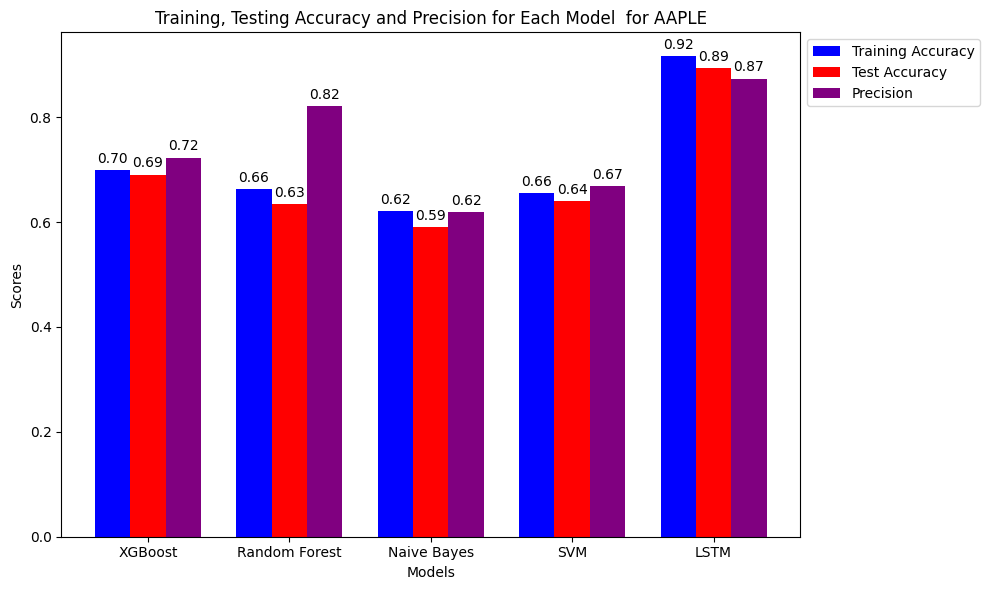

In [ ]:
# Data for the bar chart
models = ['XGBoost', 'Random Forest', 'Naive Bayes', 'SVM','LSTM']
training_accuracies = [training_acc_XGB, training_acc_RF, training_acc_NB, training_acc_SVM,train_acc_LSTM]
test_accuracies = [test_acc_XGB, test_acc_RF, test_acc_NB, test_acc_SVM,test_acc_LSTM]
precisions = [test_prec_XGB, test_prec_RF, test_prec_NB, test_prec_SVM,prec_LSTM]

# Set the positions for the bars
x = np.arange(len(models))
width = 0.25  # the width of the bars

# Define colors for each bar group
train_color = 'blue'  # Blue for training accuracy
test_color = 'red'   # Orange for test accuracy
prec_color = 'purple'   # Green for precision

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars with specified colors
rects1 = ax.bar(x - width, training_accuracies, width, label='Training Accuracy', color=train_color)
rects2 = ax.bar(x, test_accuracies, width, label='Test Accuracy', color=test_color)
rects3 = ax.bar(x + width, precisions, width, label='Precision', color=prec_color)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Training, Testing Accuracy and Precision for Each Model  for AAPLE')
ax.set_xticks(x)
ax.set_xticklabels(models)

# Adjusting the legend position outside the plot to avoid overlap
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add values on top of the bars for readability
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call function to add values
add_values(rects1)
add_values(rects2)
add_values(rects3)

# Display the plot with adjusted layout to make room for the legend
plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------

#Gold

# The data of gold is available from 2004 and not 2000 compared to AAPL

In [ ]:

# Define date range
start, end = "2000-01-01", "2025-03-01"

# 1) Download GLD with all OHLCV columns
gold = yf.download("GLD", start=start, end=end)[["Close", "High", "Low", "Open", "Volume"]]
gold.index.name = "Date"

# 2) Download DXY close only and rename
dxy = yf.download("DX-Y.NYB", start=start, end=end)[["Close"]].rename(columns={"Close": "DXY"})
dxy.index.name = "Date"

# 3) Download Federal Funds Rate close only and rename
ffr = yf.download("^IRX", start=start, end=end)[["Close"]].rename(columns={"Close": "FFR"})
ffr.index.name = "Date"

# 4) Join all three (gold, dxy, ffr) on the Date index
merged = gold.join([dxy, ffr], how="inner")

# 5) Reset index to make Date a column again
merged = merged.reset_index()

# Rename columns for clarity
merged.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'DXY', 'FFR']

# Show the first few rows of the merged data
merged.tail()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume,DXY,FFR
5091,2025-02-24,272.209991,272.320007,270.380005,271.450012,5374400,106.599998,4.190
5092,2025-02-25,268.619995,271.679993,266.450012,271.459991,10079800,106.309998,4.182
5093,2025-02-26,269.029999,269.079987,266.660004,267.079987,7276000,106.419998,4.193
5094,2025-02-27,264.929993,266.670013,264.450012,266.489990,9374600,107.239998,4.195
5095,2025-02-28,263.269989,263.399994,261.250000,262.559998,11504500,107.610001,4.193


In [ ]:
gold_data = merged
gold_data.head()

,Date,Close,High,Low,Open,Volume,DXY,FFR
0,2004-11-18,44.380001,44.490002,44.070000,44.430000,5992000,83.690002,2.087
1,2004-11-19,44.779999,44.919998,44.470001,44.490002,11655300,83.309998,2.096
2,2004-11-22,44.950001,44.970001,44.740002,44.750000,11996000,83.190002,2.122
3,2004-11-23,44.750000,44.919998,44.720001,44.880001,3169200,82.970001,2.134
4,2004-11-24,45.049999,45.049999,44.790001,44.930000,6105100,82.410004,2.132


In [ ]:
gold_data.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
DXY,0
FFR,0


In [ ]:
gold_data['Lag1'] = gold_data['Close'].shift(1)
gold_data['Lag5'] = gold_data['Close'].shift(5)
gold_data['Lag17'] = gold_data['Close'].shift(17)
gold_data['Lag30'] = gold_data['Close'].shift(30)


In [ ]:
gold_data['SMA_20'] = gold_data['Close'].rolling(window=20).mean()

# Add Exponential Moving Average (EMA)
gold_data['EMA_12'] = gold_data['Close'].ewm(span=12, adjust=False).mean()
gold_data['EMA_26'] = gold_data['Close'].ewm(span=26, adjust=False).mean()

# Add RSI
delta = gold_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
gold_data['RSI'] = 100 - (100 / (1 + rs))

# Add MACD
gold_data['MACD'] = gold_data['EMA_12'] - gold_data['EMA_26']
gold_data['Signal_Line'] = gold_data['MACD'].ewm(span=9, adjust=False).mean()

# Add Bollinger Bands
gold_data['Upper_Band'] = gold_data['SMA_20'] + (2 * gold_data['Close'].rolling(window=20).std())
gold_data['Lower_Band'] = gold_data['SMA_20'] - (2 * gold_data['Close'].rolling(window=20).std())

gold_data['True_Range'] = pd.concat([gold_data['High'] - gold_data['Low'],
                                     (gold_data['High'] - gold_data['Close'].shift()).abs(),
                                     (gold_data['Low'] - gold_data['Close'].shift()).abs()], axis=1).max(axis=1)
gold_data['ATR'] = gold_data['True_Range'].rolling(window=14).mean()

# Add Stochastic Oscillator
gold_data['Stochastic'] = 100 * (gold_data['Close'] - gold_data['Low'].rolling(window=14).min()) / (gold_data['High'].rolling(window=14).max() - gold_data['Low'].rolling(window=14).min())

# Top recommended transformations:
gold_data['RSI_EMA'] = gold_data['RSI'].ewm(span=14).mean()
gold_data['Stochastic_SMA'] = gold_data['Stochastic'].rolling(14).mean()
gold_data['Day_of_Week'] = gold_data['Date'].dt.dayofweek  # This gives the name of the day
gold_data['Month'] = gold_data['Date'].dt.month


In [ ]:
gold_data['Year'] = gold_data['Date'].dt.year

In [ ]:
# Example data: Let's say df['Close'] is your closing price data
gold_data['Return'] = gold_data['Close'].pct_change()  # Calculate daily returns (percentage change)

# Calculate the sign return: +1 if the return is positive, -1 if negative
gold_data['Sign_Return'] = gold_data['Return'].apply(lambda x: 1 if x > 0 else 0)

# Display the first few rows of the dataframe
gold_data.head()

,Date,Close,High,Low,Open,Volume,DXY,FFR,Lag1,Lag5,...,True_Range,ATR,Stochastic,RSI_EMA,Stochastic_SMA,Day_of_Week,Month,Year,Return,Sign_Return
0,2004-11-18,44.380001,44.490002,44.070000,44.430000,5992000,83.690002,2.087,NaN,NaN,...,0.420002,NaN,NaN,NaN,NaN,3,11,2004,NaN,0
1,2004-11-19,44.779999,44.919998,44.470001,44.490002,11655300,83.309998,2.096,44.380001,NaN,...,0.539997,NaN,NaN,NaN,NaN,4,11,2004,0.009013,1
2,2004-11-22,44.950001,44.970001,44.740002,44.750000,11996000,83.190002,2.122,44.779999,NaN,...,0.230000,NaN,NaN,NaN,NaN,0,11,2004,0.003796,1
3,2004-11-23,44.750000,44.919998,44.720001,44.880001,3169200,82.970001,2.134,44.950001,NaN,...,0.230000,NaN,NaN,NaN,NaN,1,11,2004,-0.004449,0
4,2004-11-24,45.049999,45.049999,44.790001,44.930000,6105100,82.410004,2.132,44.750000,NaN,...,0.299999,NaN,NaN,NaN,NaN,2,11,2004,0.006704,1


In [ ]:
gold_data.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
DXY,0
FFR,0
Lag1,1
Lag5,5


In [ ]:
gold_data.dropna(inplace=True)

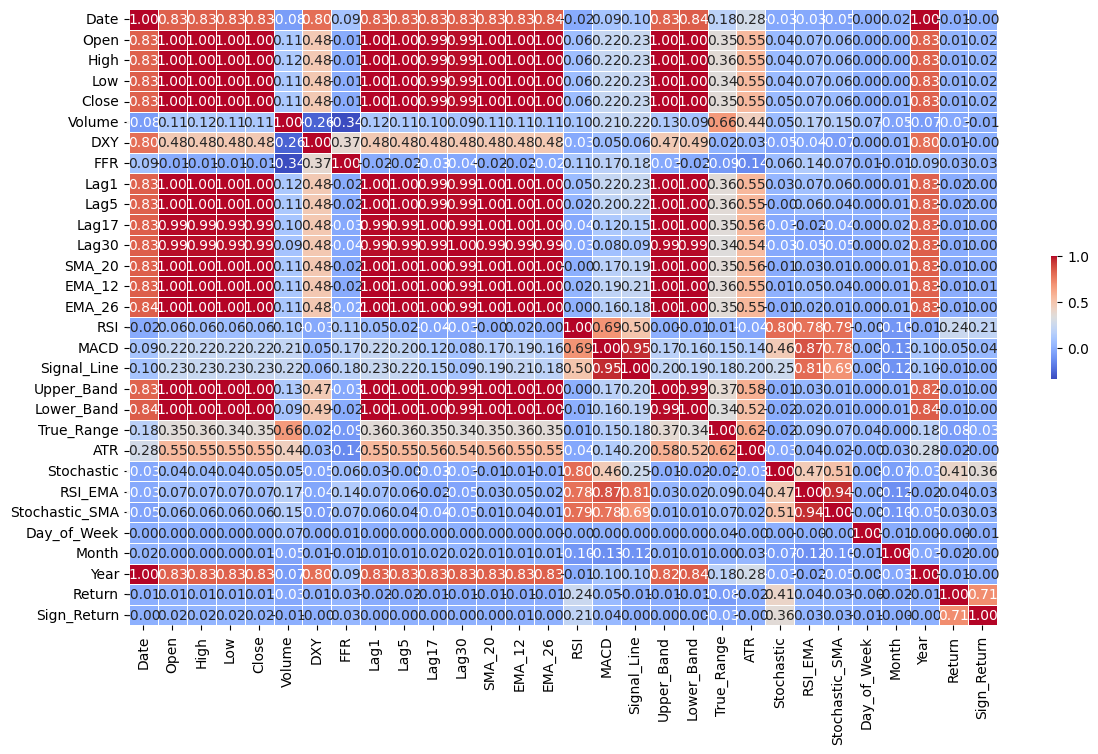

In [ ]:
plt.figure(figsize=(14,8))
correlation = gold_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10}, linewidths=0.4, cbar_kws={'shrink': 0.2})
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif # import the function from the module

cols = ['Close', 'High', 'Low', 'Open', 'Volume','Year','DXY','FFR',
       'Lag1', 'Lag5','Lag17','Lag30','SMA_20', 'EMA_12',
       'EMA_26', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band',
       'True_Range', 'ATR', 'Stochastic', 'Day_of_Week', 'Month','RSI_EMA', 'Stochastic_SMA']

mi = mutual_info_classif(gold_data[cols], gold_data['Sign_Return'])
print(pd.DataFrame({'Feature':cols, 'MI_Score':mi}).sort_values('MI_Score', ascending=False))

           Feature  MI_Score
22      Stochastic  0.094076
15             RSI  0.032081
1             High  0.022325
17     Signal_Line  0.015771
24           Month  0.012798
20      True_Range  0.011690
2              Low  0.010805
11           Lag30  0.010320
4           Volume  0.008142
9             Lag5  0.006952
21             ATR  0.005011
3             Open  0.004888
26  Stochastic_SMA  0.003997
5             Year  0.003976
6              DXY  0.002549
12          SMA_20  0.001931
8             Lag1  0.001519
0            Close  0.000000
7              FFR  0.000000
10           Lag17  0.000000
16            MACD  0.000000
13          EMA_12  0.000000
14          EMA_26  0.000000
18      Upper_Band  0.000000
19      Lower_Band  0.000000
23     Day_of_Week  0.000000
25         RSI_EMA  0.000000


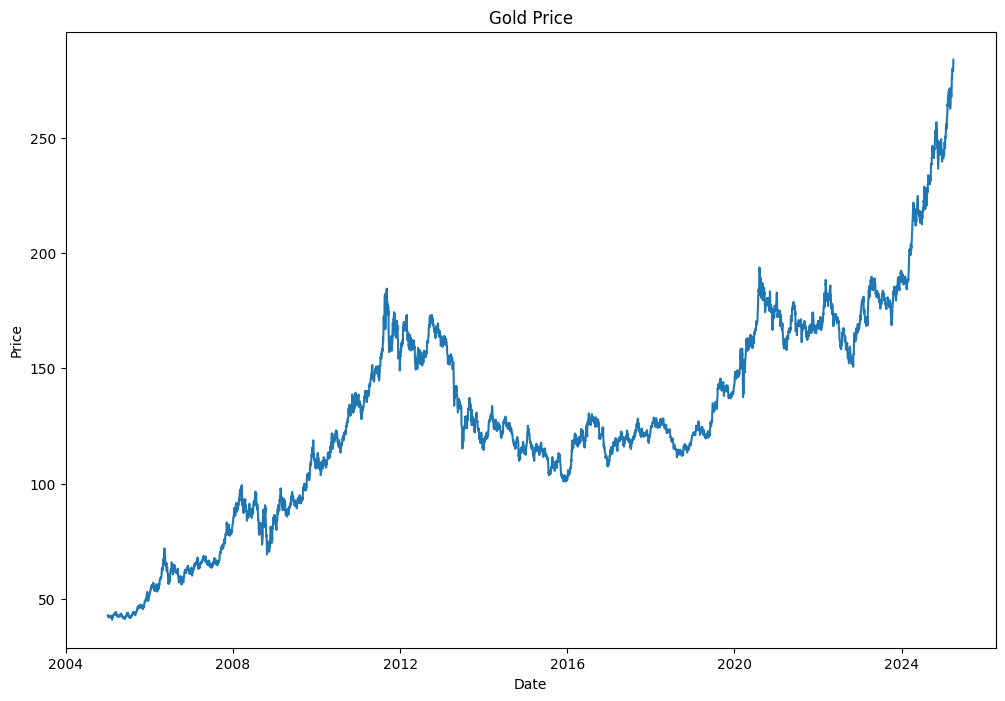

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(gold_data['Date'],gold_data['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Price')
plt.show()

In [ ]:
gold_data['Sign_Return'].value_counts()

,count
Sign_Return,
1,2676
0,2410


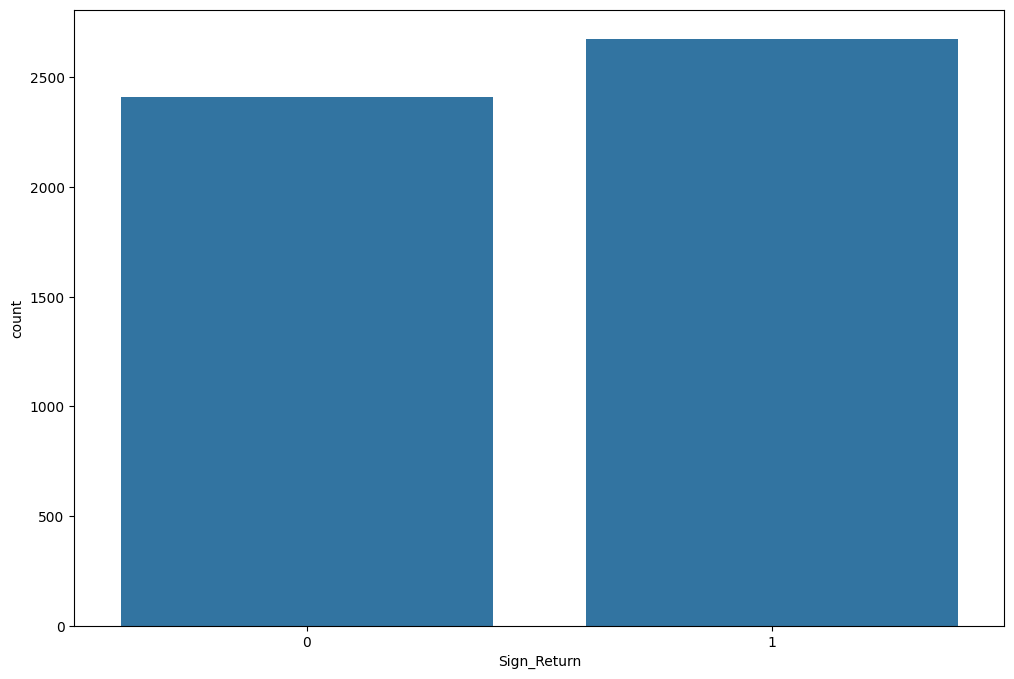

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(gold_data['Sign_Return'].value_counts())
plt.show()

#Normalization

In [ ]:
# Normalize all columns except 'Date' and 'Sign_Return'
for column in gold_data.columns:
    if column != 'Date' and column != 'Sign_Return':  # Exclude 'Date' and 'Sign_Return' from normalization
        gold_data[column] = gold_data[column].divide(gold_data[column].max())

#Feature Selection
I will select the features with highest score and drop the features that are highly correlated

In [ ]:
gold_cols = ['RSI','Stochastic','Day_of_Week','Volume','MACD','RSI_EMA','Year','Lag30','DXY','FFR']

# i will use the same functions (same as AAPL)

In [ ]:
split_date_gold = '2022-01-01'

In [ ]:
X_train_scaled_g, X_test_scaled_g, y_train_g, y_test_g = preprocess_data(gold_data,split_date_gold,gold_cols)

#XGB

Fold 1: Training Accuracy = 0.6418
Fold 1: Testing Accuracy = 0.6418
Fold 2: Training Accuracy = 0.6392
Fold 2: Testing Accuracy = 0.6392
Fold 3: Training Accuracy = 0.6675
Fold 3: Testing Accuracy = 0.6675
Fold 4: Training Accuracy = 0.7088
Fold 4: Testing Accuracy = 0.7088
Fold 5: Training Accuracy = 0.7036
Fold 5: Testing Accuracy = 0.7036
Fold 6: Training Accuracy = 0.6443
Fold 6: Testing Accuracy = 0.6443
Fold 7: Training Accuracy = 0.6907
Fold 7: Testing Accuracy = 0.6907
Fold 8: Training Accuracy = 0.6778
Fold 8: Testing Accuracy = 0.6778
Fold 9: Training Accuracy = 0.6649
Fold 9: Testing Accuracy = 0.6649
Fold 10: Training Accuracy = 0.6881
Fold 10: Testing Accuracy = 0.6881
Final Model Test Accuracy: 0.6705
Final Model Training Accuracy: 0.7022
Final Model Precision: 0.6988
Final Model Recall: 0.6706
Final Model F1 Score: 0.6844
Final Model Confusion Matrix:
[[248 122]
 [139 283]]

XGBoost Metrics:
Accuracy: 0.6704545454545454, Precision: 0.6987654320987654, Recall: 0.67061611

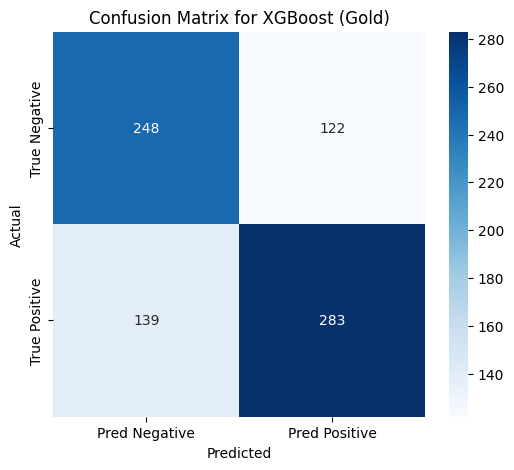

In [ ]:
xgb_metrics_g = train_and_evaluate_model(model_xgb, X_train_scaled_g, X_test_scaled_g,
                                      y_train_g, y_test_g, 'XGBoost')

# Access the metrics for XGBoost
print("\nXGBoost Metrics:")
print(f"Accuracy: {xgb_metrics_g['XGBoost']['Final Test Accuracy']}, Precision: {xgb_metrics_g['XGBoost']['Precision']}, Recall: {xgb_metrics_g['XGBoost']['Recall']}")

# Visualizing the Confusion Matrix
cm_xgb = xgb_metrics_g['XGBoost']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for XGBoost (Gold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#RF

Fold 1: Training Accuracy = 0.6082
Fold 1: Testing Accuracy = 0.6082
Fold 2: Training Accuracy = 0.6082
Fold 2: Testing Accuracy = 0.6082
Fold 3: Training Accuracy = 0.6495
Fold 3: Testing Accuracy = 0.6495
Fold 4: Training Accuracy = 0.6340
Fold 4: Testing Accuracy = 0.6340
Fold 5: Training Accuracy = 0.6211
Fold 5: Testing Accuracy = 0.6211
Fold 6: Training Accuracy = 0.6572
Fold 6: Testing Accuracy = 0.6572
Fold 7: Training Accuracy = 0.6469
Fold 7: Testing Accuracy = 0.6469
Fold 8: Training Accuracy = 0.5876
Fold 8: Testing Accuracy = 0.5876
Fold 9: Training Accuracy = 0.6289
Fold 9: Testing Accuracy = 0.6289
Fold 10: Training Accuracy = 0.6495
Fold 10: Testing Accuracy = 0.6495
Final Model Test Accuracy: 0.6338
Final Model Training Accuracy: 0.6444
Final Model Precision: 0.8028
Final Model Recall: 0.4147
Final Model F1 Score: 0.5469
Final Model Confusion Matrix:
[[327  43]
 [247 175]]

Random Forest Metrics:
Accuracy: 0.6338383838383839, Precision: 0.8027522935779816, Recall: 0.41

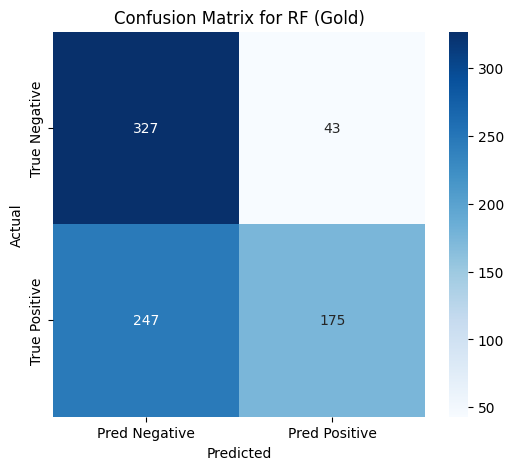

In [ ]:
# Train and evaluate the model for Random Forest
rf_metrics_g = train_and_evaluate_model(model_rf, X_train_scaled_g, X_test_scaled_g, y_train_g, y_test_g, 'RF')

# Access the metrics for Random Forest
print("\nRandom Forest Metrics:")
print(f"Accuracy: {rf_metrics_g['RF']['Final Test Accuracy']}, Precision: {rf_metrics_g['RF']['Precision']}, Recall: {rf_metrics_g['RF']['Recall']}")

# Visualizing the Confusion Matrix for Random Forest
cm_rf = rf_metrics_g['RF']['Confusion Matrix']


# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for RF (Gold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# NB

Fold 1: Training Accuracy = 0.5954
Fold 1: Testing Accuracy = 0.5954
Fold 2: Training Accuracy = 0.5464
Fold 2: Testing Accuracy = 0.5464
Fold 3: Training Accuracy = 0.6160
Fold 3: Testing Accuracy = 0.6160
Fold 4: Training Accuracy = 0.6211
Fold 4: Testing Accuracy = 0.6211
Fold 5: Training Accuracy = 0.5619
Fold 5: Testing Accuracy = 0.5619
Fold 6: Training Accuracy = 0.5928
Fold 6: Testing Accuracy = 0.5928
Fold 7: Training Accuracy = 0.6469
Fold 7: Testing Accuracy = 0.6469
Fold 8: Training Accuracy = 0.5928
Fold 8: Testing Accuracy = 0.5928
Fold 9: Training Accuracy = 0.6263
Fold 9: Testing Accuracy = 0.6263
Fold 10: Training Accuracy = 0.6392
Fold 10: Testing Accuracy = 0.6392
Final Model Test Accuracy: 0.6212
Final Model Training Accuracy: 0.6123
Final Model Precision: 0.6260
Final Model Recall: 0.7180
Final Model F1 Score: 0.6689
Final Model Confusion Matrix:
[[189 181]
 [119 303]]

Naive Bayes Metrics:
Accuracy: 0.6212121212121212, Precision: 0.6260330578512396, Recall: 0.7180

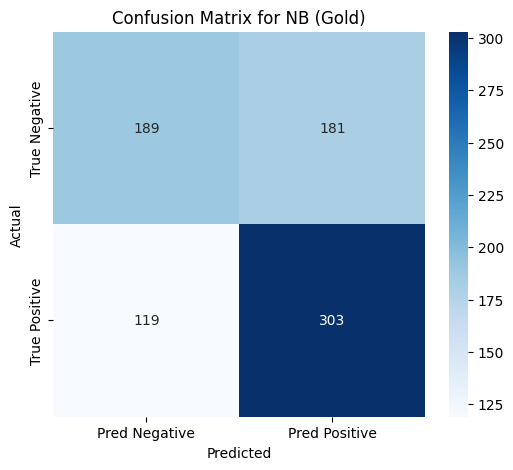

In [ ]:

# Train and evaluate the Naive Bayes model
nb_metrics_g = train_and_evaluate_model(model_nb, X_train_scaled_g, X_test_scaled_g, y_train_g, y_test_g, 'NB')

# Access the metrics for Naive Bayes
print("\nNaive Bayes Metrics:")
print(f"Accuracy: {nb_metrics_g['NB']['Final Test Accuracy']}, Precision: {nb_metrics_g['NB']['Precision']}, Recall: {nb_metrics_g['NB']['Recall']}")

# Visualizing the Confusion Matrix for Naive Bayes
cm_nb = nb_metrics_g['NB']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for NB (Gold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#SVM

Fold 1: Training Accuracy = 0.5928
Fold 1: Testing Accuracy = 0.5928
Fold 2: Training Accuracy = 0.6289
Fold 2: Testing Accuracy = 0.6289
Fold 3: Training Accuracy = 0.6366
Fold 3: Testing Accuracy = 0.6366
Fold 4: Training Accuracy = 0.6289
Fold 4: Testing Accuracy = 0.6289
Fold 5: Training Accuracy = 0.6082
Fold 5: Testing Accuracy = 0.6082
Fold 6: Training Accuracy = 0.6289
Fold 6: Testing Accuracy = 0.6289
Fold 7: Training Accuracy = 0.6701
Fold 7: Testing Accuracy = 0.6701
Fold 8: Training Accuracy = 0.6263
Fold 8: Testing Accuracy = 0.6263
Fold 9: Training Accuracy = 0.6521
Fold 9: Testing Accuracy = 0.6521
Fold 10: Training Accuracy = 0.6804
Fold 10: Testing Accuracy = 0.6804
Final Model Test Accuracy: 0.6528
Final Model Training Accuracy: 0.6453
Final Model Precision: 0.6541
Final Model Recall: 0.7393
Final Model F1 Score: 0.6941
Final Model Confusion Matrix:
[[205 165]
 [110 312]]

SVM Metrics:
Accuracy: 0.6527777777777778, Precision: 0.6540880503144654, Recall: 0.739336492890

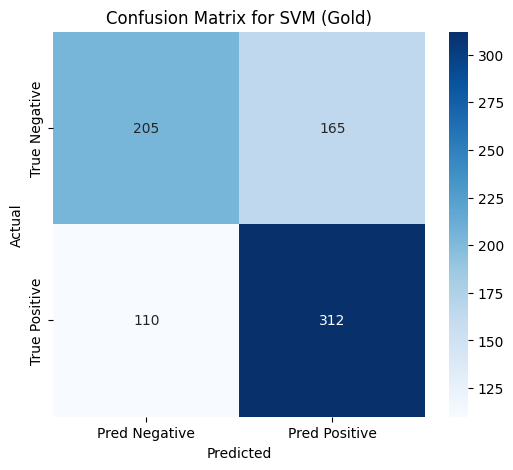

In [ ]:

# Train and evaluate the SVM model
svm_metrics_g = train_and_evaluate_model(model_svm, X_train_scaled_g, X_test_scaled_g, y_train_g, y_test_g, 'SVM')

# Access the metrics for SVM
print("\nSVM Metrics:")
print(f"Accuracy: {svm_metrics_g['SVM']['Final Test Accuracy']}, Precision: {svm_metrics_g['SVM']['Precision']}, Recall: {svm_metrics_g['SVM']['Recall']}")

# Visualizing the Confusion Matrix for SVM
cm_svm = svm_metrics_g['SVM']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for SVM (Gold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#LSTM

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Ensures that CUDA operations are deterministic
np.random.seed(seed)
random.seed(seed)
X_train = torch.tensor(X_train_scaled_g, dtype=torch.float32)
y_train = torch.tensor(y_train_g.values, dtype=torch.float32).unsqueeze(1)  # (N, 1)
X_test = torch.tensor(X_test_scaled_g, dtype=torch.float32)
y_test = torch.tensor(y_test_g.values, dtype=torch.float32).unsqueeze(1)

# Define the model with LSTM layer
class BinaryLSTMNet(nn.Module):
    def __init__(self, in_features, h1=132, h2=64, lstm_hidden_size=64, num_lstm_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(in_features, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, 1)  # single logit

        # Manually initialize the weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        # Pass through LSTM layer
        x, _ = self.lstm(x)  # Get the output of all timesteps

        # Feed through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)  # raw logit
        return x

# Initialize the model
model_g = BinaryLSTMNet(in_features=X_train.shape[1])

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_g.parameters(), lr=1e-4)

# Training loop
epochs = 300
train_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    model_g.train()
    optimizer.zero_grad()

    logits = model_g(X_train)  # raw logits (no sigmoid)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0 or epoch == 1:
        with torch.no_grad():
            model_g.eval()
            test_logits_g = model_g(X_test)
            test_probs_g = torch.sigmoid(test_logits_g)
            test_pred_g = (test_probs_g >= 0.5).float()

        acc = accuracy_score(y_test, test_pred)
        val_accuracies.append(acc)
        print(f"Epoch {epoch:3d} — loss: {loss.item():.4f}  test‑acc: {acc:.4f}")

# Final evaluation on the test set
with torch.no_grad():
    model_g.eval()
    logits = model_g(X_test)
    probs_g = torch.sigmoid(logits)
    preds_g = (probs_g >= 0.5).float()

# Test set results
test_acc_LSTM_g = accuracy_score(y_test, preds_g)
prec_LSTM_g = precision_score(y_test, preds_g, zero_division=0)
rec_g = recall_score(y_test, preds_g, zero_division=0)
cm_g = confusion_matrix(y_test, preds_g)

# Training set results
with torch.no_grad():
    model.eval()
    train_logits_g = model_g(X_train)
    train_probs_g = torch.sigmoid(train_logits_g)
    train_pred_g = (train_probs_g >= 0.5).float()

train_acc_LSTM_g = accuracy_score(y_train, train_pred)

# Output final results
print("\nFinal Test Results:")
print(f"Accuracy : {test_acc_LSTM_g:.4f}")
print(f"Precision: {prec_LSTM_g:.4f}")
print(f"Recall   : {rec_g:.4f}")
print("Confusion Matrix:")
print(cm_g)

# Final Training Accuracy
print(f"Final Training Accuracy: {train_acc_LSTM_g:.4f}")

Epoch   1 — loss: 0.6919  test‑acc: 0.8902
Epoch  10 — loss: 0.6913  test‑acc: 0.8902
Epoch  20 — loss: 0.6912  test‑acc: 0.8902
Epoch  30 — loss: 0.6910  test‑acc: 0.8902
Epoch  40 — loss: 0.6908  test‑acc: 0.8902
Epoch  50 — loss: 0.6906  test‑acc: 0.8902
Epoch  60 — loss: 0.6903  test‑acc: 0.8902
Epoch  70 — loss: 0.6899  test‑acc: 0.8902
Epoch  80 — loss: 0.6895  test‑acc: 0.8902
Epoch  90 — loss: 0.6889  test‑acc: 0.8902
Epoch 100 — loss: 0.6880  test‑acc: 0.8902
Epoch 110 — loss: 0.6868  test‑acc: 0.8902
Epoch 120 — loss: 0.6850  test‑acc: 0.8902
Epoch 130 — loss: 0.6826  test‑acc: 0.8902
Epoch 140 — loss: 0.6791  test‑acc: 0.8902
Epoch 150 — loss: 0.6737  test‑acc: 0.8902
Epoch 160 — loss: 0.6647  test‑acc: 0.8902
Epoch 170 — loss: 0.6483  test‑acc: 0.8902
Epoch 180 — loss: 0.6191  test‑acc: 0.8902
Epoch 190 — loss: 0.5758  test‑acc: 0.8902
Epoch 200 — loss: 0.5189  test‑acc: 0.8902
Epoch 210 — loss: 0.4448  test‑acc: 0.8902
Epoch 220 — loss: 0.3661  test‑acc: 0.8902
Epoch 230 —

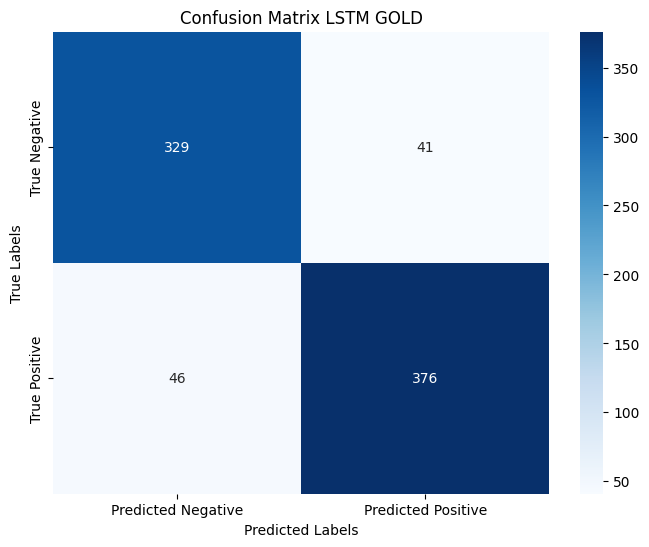

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_g, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title("Confusion Matrix LSTM GOLD")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#PL and Backtesting

In [ ]:
gold_data.shape

(5066, 30)

In [ ]:
# --- Preprocessing function ---
def preprocess_data_gold(data, split_date, columns):
    train_data = data[data['Date'] < split_date]
    test_data = data[data['Date'] >= split_date].copy()

    X_train = train_data[columns]
    y_train = train_data['Sign_Return']
    X_test = test_data[columns]
    y_test = test_data['Sign_Return']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, test_data

#Assuming col_LSTM is the correct feature set for the LSTM model
# --- Preprocess gold data using the col_LSTM features ---
X_train_scaled_gold, X_test_scaled_gold, y_train_gold, y_test_gold, test_df_gold = preprocess_data_gold(gold_data, split_date_gold, gold_cols) # Use col_LSTM instead of columns

# ... (rest of the code)


# --- Define classical models ---
models_gold = {
    'XGBoost': model_xgb,
    'RandomForest': model_rf,
    'NaiveBayes': model_nb,
    'SVM': model_svm
}

# --- Store results ---
results_gold = {}

# --- Backtest each classical model ---
for name, model in models_gold.items():
    print(f"\nEvaluating {name} on GOLD...")

    model.fit(X_train_scaled_gold, y_train_gold)

    try:
        y_proba = model.predict_proba(X_test_scaled_gold)[:, 1]
    except:
        y_proba = model.predict(X_test_scaled_gold)

    threshold = 0.4
    y_pred = (y_proba >= threshold).astype(int)

    test_df_copy = test_df_gold.copy()
    test_df_copy['buy'] = y_pred
    test_df_copy['model_return'] = test_df_copy['buy'].shift(1) * test_df_copy['Return']

    total_return = (1 + test_df_copy['model_return'].dropna()).prod() - 1
    results_gold[name] = round(total_return * 100, 2)

# --- Add LSTM to backtest ---
with torch.no_grad():
    model_g.eval()
    X_test_tensor = torch.tensor(X_test_scaled_gold, dtype=torch.float32)
    lstm_logits_gold = model_g(X_test_tensor)
    lstm_probs_gold = torch.sigmoid(lstm_logits_gold)
    lstm_preds_gold = (lstm_probs_gold >= 0.5).float().cpu().numpy().flatten()

test_df_lstm_gold = test_df_gold.copy()
test_df_lstm_gold['buy'] = lstm_preds_gold
test_df_lstm_gold['model_return'] = test_df_lstm_gold['buy'].shift(1) * test_df_lstm_gold['Return']
total_return_lstm_gold = (1 + test_df_lstm_gold['model_return'].dropna()).prod() - 1
results_gold['LSTM'] = round(total_return_lstm_gold * 100, 2)

# --- Show all results ---
results_df_gold = pd.DataFrame.from_dict(results_gold, orient='index', columns=['Model Total Return (%)'])
results_df_gold = results_df_gold.sort_values('Model Total Return (%)', ascending=False)
print("\nFinal GOLD Model Returns Comparison:")
print(results_df_gold)



Evaluating XGBoost on GOLD...

Evaluating RandomForest on GOLD...

Evaluating NaiveBayes on GOLD...

Evaluating SVM on GOLD...

Final GOLD Model Returns Comparison:
              Model Total Return (%)
SVM                          1747.47
NaiveBayes                    181.27
RandomForest                  121.75
XGBoost                        88.10
LSTM                           55.42


---------------------------------------------------------------------

---------------------------------------------------

----------------------------------------------

In [ ]:
training_acc_XGB_g = xgb_metrics_g['XGBoost']['Final Train Accuracy']
test_acc_XGB_g = xgb_metrics_g['XGBoost']['Final Test Accuracy']
test_prec_XGB_g = xgb_metrics_g['XGBoost']['Precision']
test_rec_XGB_g = xgb_metrics_g['XGBoost']['Recall']
# RF
training_acc_RF_g = rf_metrics_g['RF']['Final Train Accuracy']
test_acc_RF_g = rf_metrics_g['RF']['Final Test Accuracy']
test_prec_RF_g = rf_metrics_g['RF']['Precision']
test_rec_RF_g = rf_metrics_g['RF']['Recall']
#NB
training_acc_NB_g = nb_metrics_g['NB']['Final Train Accuracy']
test_acc_NB_g = nb_metrics_g['NB']['Final Test Accuracy']
test_prec_NB_g = nb_metrics_g['NB']['Precision']
test_rec_NB_g = nb_metrics_g['NB']['Recall']
#SVM
training_acc_SVM_g = svm_metrics_g['SVM']['Final Train Accuracy']
test_acc_SVM_g = svm_metrics_g['SVM']['Final Test Accuracy']
test_prec_SVM_g = svm_metrics_g['SVM']['Precision']
test_rec_SVM_g = svm_metrics_g['SVM']['Recall']

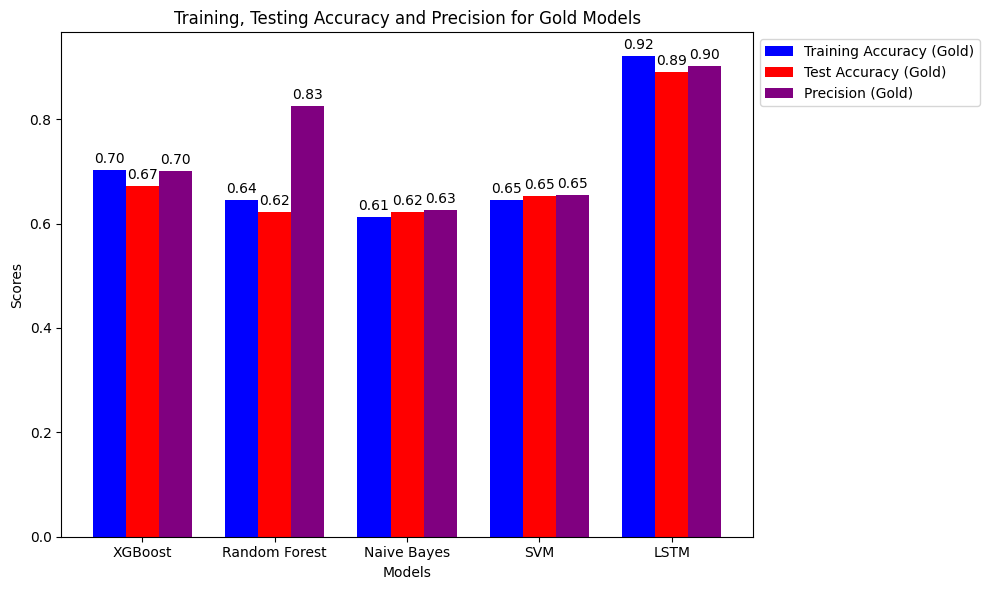

In [ ]:
import numpy as np

# Data for Gold models (replace these variables with your actual data)
models = ['XGBoost', 'Random Forest', 'Naive Bayes', 'SVM', 'LSTM']
training_accuracies_g = [training_acc_XGB_g, training_acc_RF_g, training_acc_NB_g, training_acc_SVM_g, train_acc_LSTM_g]
test_accuracies_g = [test_acc_XGB_g, test_acc_RF_g, test_acc_NB_g, test_acc_SVM_g, test_acc_LSTM_g]
precisions_g = [test_prec_XGB_g, test_prec_RF_g, test_prec_NB_g, test_prec_SVM_g, prec_LSTM_g]

# Set the positions for the bars
x = np.arange(len(models))
width = 0.25  # the width of the bars

# Define colors for each bar group
train_color = 'blue'  # Green for training accuracy
test_color = 'red'  # Orange for test accuracy
prec_color = 'purple'   # Yellow for precision

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for Gold models
rects4 = ax.bar(x - width, training_accuracies_g, width, label='Training Accuracy (Gold)', color=train_color)
rects5 = ax.bar(x, test_accuracies_g, width, label='Test Accuracy (Gold)', color=test_color)
rects6 = ax.bar(x + width, precisions_g, width, label='Precision (Gold)', color=prec_color)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Training, Testing Accuracy and Precision for Gold Models')
ax.set_xticks(x)
ax.set_xticklabels(models)

# Adjusting the legend position outside the plot to avoid overlap
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add values on top of the bars for readability
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call function to add values
add_values(rects4)
add_values(rects5)
add_values(rects6)

# Display the plot with adjusted layout to make room for the legend
plt.tight_layout()
plt.show()

#NOTE : the function add value will be used for nasdaq

# NASDAQ

In [ ]:
nasdaq_ticker = "^IXIC"

nasdaq_data = yf.download(nasdaq_ticker, start="2000-01-01", end="2025-04-01")
nasdaq_data = nasdaq_data.reset_index()
nasdaq_data[['Date','Open','High','Low','Close', 'Volume']]
nasdaq_data.columns = ['Date','Open','High','Low','Close','Volume']
nasdaq_data.head()


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
0,2000-01-03,4131.149902,4192.189941,3989.709961,4186.189941,1510070000
1,2000-01-04,3901.689941,4073.250000,3898.229980,4020.000000,1511840000
2,2000-01-05,3877.540039,3924.209961,3734.870117,3854.350098,1735670000
3,2000-01-06,3727.129883,3868.760010,3715.620117,3834.439941,1598320000
4,2000-01-07,3882.620117,3882.669922,3711.090088,3711.090088,1634930000


In [ ]:
# Create lag features
nasdaq_data['Lag1'] = nasdaq_data['Close'].shift(1)
nasdaq_data['Lag5'] = nasdaq_data['Close'].shift(5)

# Add Simple Moving Average (SMA)
nasdaq_data['SMA_20'] = nasdaq_data['Close'].rolling(window=20).mean()

# Add Exponential Moving Average (EMA)
nasdaq_data['EMA_12'] = nasdaq_data['Close'].ewm(span=12, adjust=False).mean()
nasdaq_data['EMA_26'] = nasdaq_data['Close'].ewm(span=26, adjust=False).mean()

# Add Relative Strength Index (RSI)
delta = nasdaq_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
nasdaq_data['RSI'] = 100 - (100 / (1 + rs))

# Add Moving Average Convergence Divergence (MACD)
nasdaq_data['MACD'] = nasdaq_data['EMA_12'] - nasdaq_data['EMA_26']
nasdaq_data['Signal_Line'] = nasdaq_data['MACD'].ewm(span=9, adjust=False).mean()

# Add Bollinger Bands
nasdaq_data['Upper_Band'] = nasdaq_data['SMA_20'] + (2 * nasdaq_data['Close'].rolling(window=20).std())
nasdaq_data['Lower_Band'] = nasdaq_data['SMA_20'] - (2 * nasdaq_data['Close'].rolling(window=20).std())

# Add Average True Range (ATR)
nasdaq_data['True_Range'] = pd.concat([nasdaq_data['High'] - nasdaq_data['Low'],
                                       (nasdaq_data['High'] - nasdaq_data['Close'].shift()).abs(),
                                       (nasdaq_data['Low'] - nasdaq_data['Close'].shift()).abs()], axis=1).max(axis=1)
nasdaq_data['ATR'] = nasdaq_data['True_Range'].rolling(window=14).mean()

# Add Stochastic Oscillator
nasdaq_data['Stochastic'] = 100 * (nasdaq_data['Close'] - nasdaq_data['Low'].rolling(window=14).min()) / (nasdaq_data['High'].rolling(window=14).max() - nasdaq_data['Low'].rolling(window=14).min())

# Top recommended transformations:
nasdaq_data['RSI_EMA'] = nasdaq_data['RSI'].ewm(span=14).mean()
nasdaq_data['Stochastic_SMA'] = nasdaq_data['Stochastic'].rolling(14).mean()


# Add Day of Week and Month
nasdaq_data['Day_of_Week'] = nasdaq_data['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday
nasdaq_data['Month'] = nasdaq_data['Date'].dt.month




In [ ]:

nasdaq_data['Return'] = nasdaq_data['Close'].pct_change()  # Calculate daily returns (percentage change)

# Calculate the sign return: +1 if the return is positive, 0 if negative
nasdaq_data['Sign_Return'] = nasdaq_data['Return'].apply(lambda x: 1 if x > 0 else 0)

# Display the first few rows of the dataframe
data.head()

,Date,Close,High,Low,Open,Volume,SP500,NASDAQ,Lag1,Lag5,...,ATR,Stochastic,RSI_EMA,Stochastic_SMA,Market_Sync,Day_of_Week,Month,Year,Return,Sign_Return
26,2000-02-09,0.847322,0.881178,0.845912,0.858608,299364800,1411.709961,4363.240234,0.864251,0.743406,...,0.049775,80.110268,55.543329,57.138224,0.000302,2,2,2000,-0.019587,0
27,2000-02-10,0.853906,0.856727,0.827574,0.849204,302982400,1416.829956,4485.629883,0.847322,0.777261,...,0.049674,83.977989,55.050866,58.072857,0.000102,3,2,2000,0.007770,1
28,2000-02-11,0.818170,0.858608,0.814408,0.854846,212251200,1387.119995,4395.450195,0.853906,0.812527,...,0.048734,62.983329,54.690897,58.541034,0.000422,4,2,2000,-0.041851,0
29,2000-02-14,0.871303,0.871774,0.817229,0.822401,367539200,1389.939941,4418.549805,0.818170,0.858138,...,0.046853,94.198721,54.539993,60.014402,0.000011,0,2,2000,0.064942,1
30,2000-02-15,0.895285,0.902338,0.866602,0.867072,485744000,1402.050049,4420.770020,0.871303,0.864251,...,0.047021,96.314300,55.161351,62.059792,0.000004,1,2,2000,0.027523,1


In [ ]:
nasdaq_data.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Lag1,1
Lag5,5
SMA_20,19
EMA_12,0


In [ ]:
nasdaq_data.dropna(inplace=True)

In [ ]:
for column in nasdaq_data.columns:
    if column != 'Date' and column != 'Sign_Return':  # Exclude 'Date' and 'Sign_Return' from normalization
        nasdaq_data[column] = nasdaq_data[column].divide(nasdaq_data[column].max())


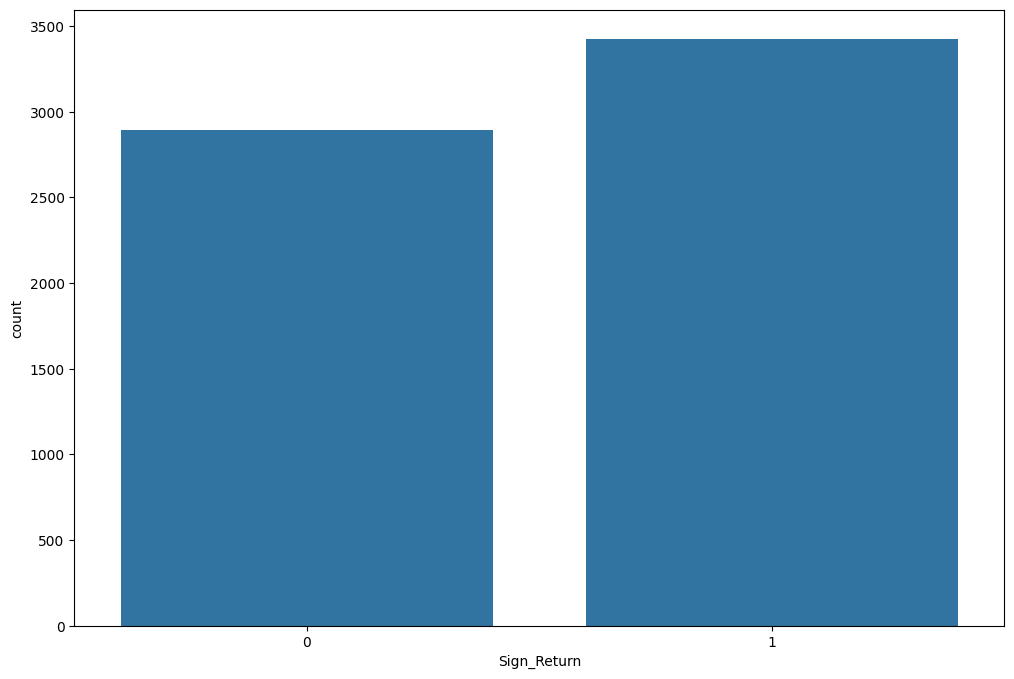

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(nasdaq_data['Sign_Return'].value_counts())
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif


In [ ]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume',
       'Lag1', 'Lag5','SMA_20', 'EMA_12',
       'EMA_26', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band',
       'True_Range', 'ATR', 'Stochastic', 'Day_of_Week', 'Month','RSI_EMA', 'Stochastic_SMA']

mi = mutual_info_classif(nasdaq_data[cols], nasdaq_data['Sign_Return'])
print(pd.DataFrame({'Feature':cols, 'MI_Score':mi}).sort_values('MI_Score', ascending=False))

           Feature  MI_Score
17      Stochastic  0.092276
10             RSI  0.027885
4           Volume  0.010748
5             Lag1  0.007259
19           Month  0.007254
16             ATR  0.006291
11            MACD  0.005055
12     Signal_Line  0.004630
3             Open  0.004502
14      Lower_Band  0.003501
2              Low  0.000000
1             High  0.000000
0            Close  0.000000
6             Lag5  0.000000
13      Upper_Band  0.000000
7           SMA_20  0.000000
8           EMA_12  0.000000
9           EMA_26  0.000000
15      True_Range  0.000000
18     Day_of_Week  0.000000
20         RSI_EMA  0.000000
21  Stochastic_SMA  0.000000


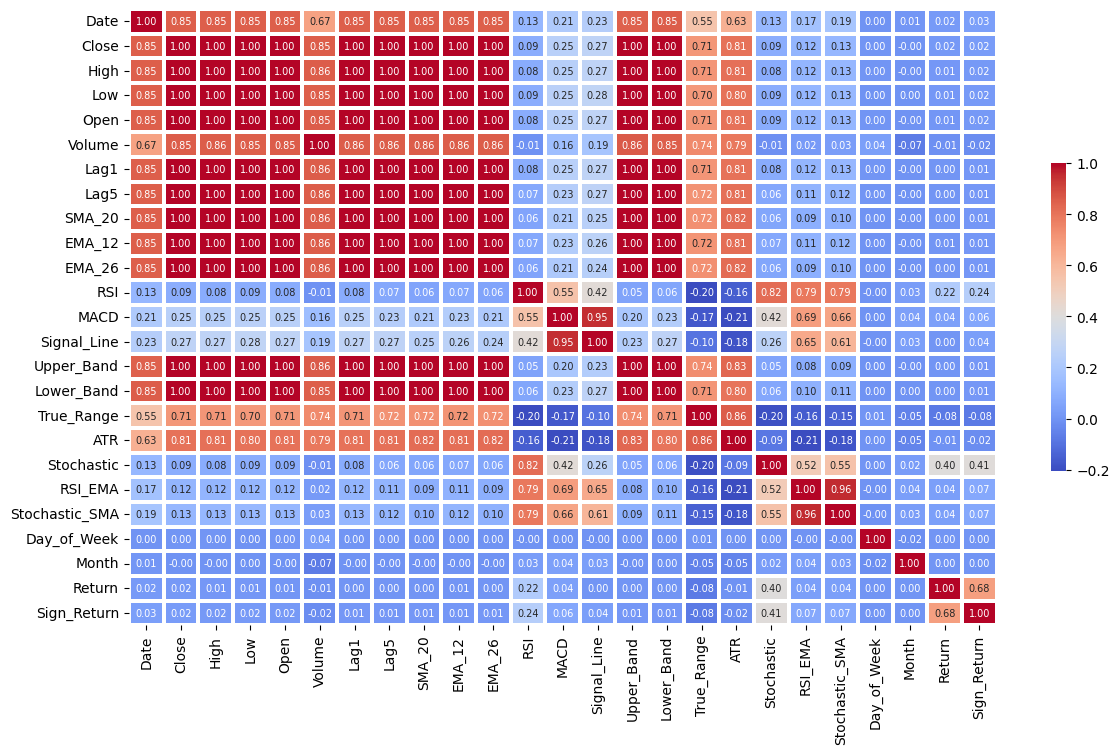

In [ ]:
plt.figure(figsize=(14,8))
correlation = nasdaq_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 7}, linewidths=1.5, cbar_kws={'shrink': 0.5})
plt.show()

In [ ]:
split_date = '2021-03-01'
# after performing feature selection , these are the columns needed
columns_nasdaq = ['RSI','Stochastic','Day_of_Week','Volume','MACD','ATR','Month']

In [ ]:
X_train_scaled_n, X_test_scaled_n, y_train_n, y_test_n = preprocess_data(nasdaq_data,split_date,columns_nasdaq)

#XGBOOST FOR NASDAQ

Fold 1: Training Accuracy = 0.6736
Fold 1: Testing Accuracy = 0.6736
Fold 2: Training Accuracy = 0.6861
Fold 2: Testing Accuracy = 0.6861
Fold 3: Training Accuracy = 0.6736
Fold 3: Testing Accuracy = 0.6736
Fold 4: Training Accuracy = 0.6632
Fold 4: Testing Accuracy = 0.6632
Fold 5: Training Accuracy = 0.6985
Fold 5: Testing Accuracy = 0.6985
Fold 6: Training Accuracy = 0.6861
Fold 6: Testing Accuracy = 0.6861
Fold 7: Training Accuracy = 0.6923
Fold 7: Testing Accuracy = 0.6923
Fold 8: Training Accuracy = 0.6861
Fold 8: Testing Accuracy = 0.6861
Fold 9: Training Accuracy = 0.6944
Fold 9: Testing Accuracy = 0.6944
Fold 10: Training Accuracy = 0.6923
Fold 10: Testing Accuracy = 0.6923
Final Model Test Accuracy: 0.6865
Final Model Training Accuracy: 0.7039
Final Model Precision: 0.6970
Final Model Recall: 0.7276
Final Model F1 Score: 0.7120
Final Model Confusion Matrix:
[[307 173]
 [149 398]]

XGBoost Metrics:
Accuracy: 0.6864654333008764, Precision: 0.6970227670753065, Recall: 0.72760511

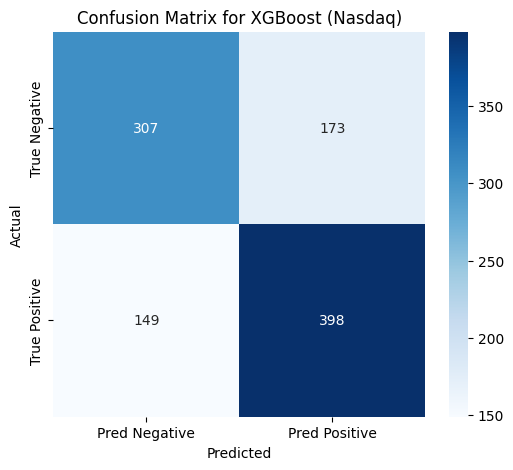

In [ ]:
xgb_metrics_n = train_and_evaluate_model(model_xgb, X_train_scaled_n, X_test_scaled_n,
                                      y_train_n, y_test_n, 'XGBoost')

# Access the metrics for XGBoost
print("\nXGBoost Metrics:")
print(f"Accuracy: {xgb_metrics_n['XGBoost']['Final Test Accuracy']}, Precision: {xgb_metrics_n['XGBoost']['Precision']}, Recall: {xgb_metrics_n['XGBoost']['Recall']}")

# Visualizing the Confusion Matrix
cm_xgb = xgb_metrics_n['XGBoost']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for XGBoost (Nasdaq)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#RF

Fold 1: Training Accuracy = 0.6320
Fold 1: Testing Accuracy = 0.6320
Fold 2: Training Accuracy = 0.6299
Fold 2: Testing Accuracy = 0.6299
Fold 3: Training Accuracy = 0.6445
Fold 3: Testing Accuracy = 0.6445
Fold 4: Training Accuracy = 0.6570
Fold 4: Testing Accuracy = 0.6570
Fold 5: Training Accuracy = 0.6528
Fold 5: Testing Accuracy = 0.6528
Fold 6: Training Accuracy = 0.6320
Fold 6: Testing Accuracy = 0.6320
Fold 7: Training Accuracy = 0.6403
Fold 7: Testing Accuracy = 0.6403
Fold 8: Training Accuracy = 0.6445
Fold 8: Testing Accuracy = 0.6445
Fold 9: Training Accuracy = 0.6632
Fold 9: Testing Accuracy = 0.6632
Fold 10: Training Accuracy = 0.6819
Fold 10: Testing Accuracy = 0.6819
Final Model Test Accuracy: 0.6641
Final Model Training Accuracy: 0.6505
Final Model Precision: 0.7244
Final Model Recall: 0.5960
Final Model F1 Score: 0.6540
Final Model Confusion Matrix:
[[356 124]
 [221 326]]

Random Forest Metrics:
Accuracy: 0.6640701071080818, Precision: 0.7244444444444444, Recall: 0.59

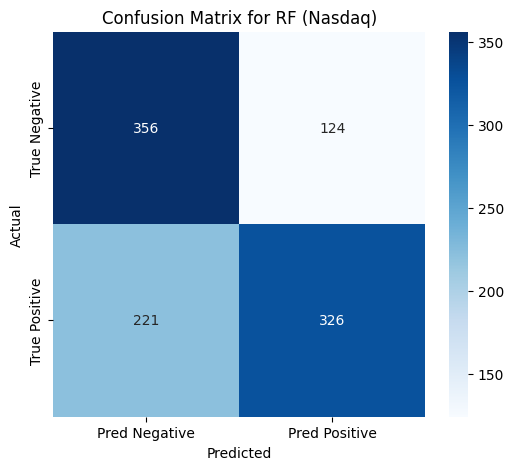

In [ ]:
# Train and evaluate the model for Random Forest
rf_metrics_n= train_and_evaluate_model(model_rf, X_train_scaled_n, X_test_scaled_n, y_train_n, y_test_n, 'RF')

# Access the metrics for Random Forest
print("\nRandom Forest Metrics:")
print(f"Accuracy: {rf_metrics_n['RF']['Final Test Accuracy']}, Precision: {rf_metrics_n['RF']['Precision']}, Recall: {rf_metrics_n['RF']['Recall']}")

# Visualizing the Confusion Matrix for Random Forest
cm_rf = rf_metrics_n['RF']['Confusion Matrix']


# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for RF (Nasdaq)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#NB

Fold 1: Training Accuracy = 0.5904
Fold 1: Testing Accuracy = 0.5904
Fold 2: Training Accuracy = 0.6279
Fold 2: Testing Accuracy = 0.6279
Fold 3: Training Accuracy = 0.6341
Fold 3: Testing Accuracy = 0.6341
Fold 4: Training Accuracy = 0.6216
Fold 4: Testing Accuracy = 0.6216
Fold 5: Training Accuracy = 0.6299
Fold 5: Testing Accuracy = 0.6299
Fold 6: Training Accuracy = 0.6486
Fold 6: Testing Accuracy = 0.6486
Fold 7: Training Accuracy = 0.6445
Fold 7: Testing Accuracy = 0.6445
Fold 8: Training Accuracy = 0.6195
Fold 8: Testing Accuracy = 0.6195
Fold 9: Training Accuracy = 0.6341
Fold 9: Testing Accuracy = 0.6341
Fold 10: Training Accuracy = 0.5177
Fold 10: Testing Accuracy = 0.5177
Final Model Test Accuracy: 0.6183
Final Model Training Accuracy: 0.6295
Final Model Precision: 0.5987
Final Model Recall: 0.8592
Final Model F1 Score: 0.7057
Final Model Confusion Matrix:
[[165 315]
 [ 77 470]]

Naive Bayes Metrics:
Accuracy: 0.6183057448880234, Precision: 0.5987261146496815, Recall: 0.8592

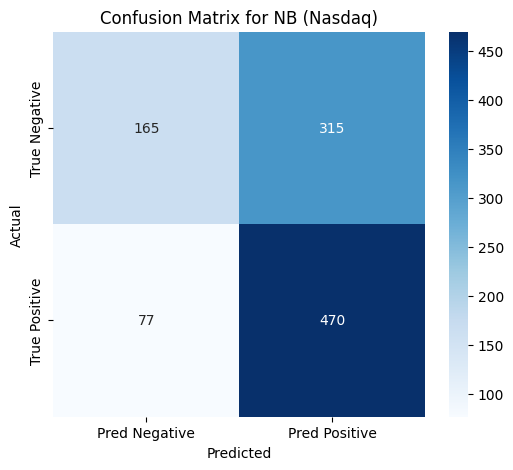

In [ ]:
nb_metrics_n= train_and_evaluate_model(model_nb, X_train_scaled_n, X_test_scaled_n, y_train_n, y_test_n, 'NB')

# Access the metrics for Naive Bayes
print("\nNaive Bayes Metrics:")
print(f"Accuracy: {nb_metrics_n['NB']['Final Test Accuracy']}, Precision: {nb_metrics_n['NB']['Precision']}, Recall: {nb_metrics_n['NB']['Recall']}")

# Visualizing the Confusion Matrix for Naive Bayes
cm_nb = nb_metrics_n['NB']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for NB (Nasdaq)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#SVM

Fold 1: Training Accuracy = 0.6008
Fold 1: Testing Accuracy = 0.6008
Fold 2: Training Accuracy = 0.6383
Fold 2: Testing Accuracy = 0.6383
Fold 3: Training Accuracy = 0.6590
Fold 3: Testing Accuracy = 0.6590
Fold 4: Training Accuracy = 0.6424
Fold 4: Testing Accuracy = 0.6424
Fold 5: Training Accuracy = 0.6445
Fold 5: Testing Accuracy = 0.6445
Fold 6: Training Accuracy = 0.6528
Fold 6: Testing Accuracy = 0.6528
Fold 7: Training Accuracy = 0.6653
Fold 7: Testing Accuracy = 0.6653
Fold 8: Training Accuracy = 0.6466
Fold 8: Testing Accuracy = 0.6466
Fold 9: Training Accuracy = 0.6674
Fold 9: Testing Accuracy = 0.6674
Fold 10: Training Accuracy = 0.6715
Fold 10: Testing Accuracy = 0.6715
Final Model Test Accuracy: 0.6748
Final Model Training Accuracy: 0.6630
Final Model Precision: 0.6721
Final Model Recall: 0.7605
Final Model F1 Score: 0.7136
Final Model Confusion Matrix:
[[277 203]
 [131 416]]

SVM Metrics:
Accuracy: 0.6747809152872444, Precision: 0.6720516962843296, Recall: 0.760511882998

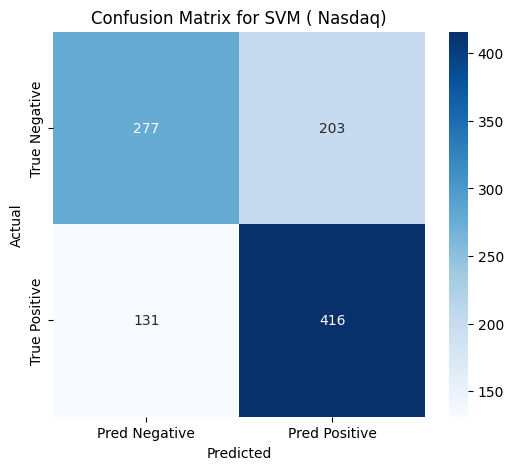

In [ ]:
svm_metrics_n = train_and_evaluate_model(model_svm, X_train_scaled_n, X_test_scaled_n, y_train_n, y_test_n, 'SVM')

# Access the metrics for SVM
print("\nSVM Metrics:")
print(f"Accuracy: {svm_metrics_n['SVM']['Final Test Accuracy']}, Precision: {svm_metrics_n['SVM']['Precision']}, Recall: {svm_metrics_n['SVM']['Recall']}")

# Visualizing the Confusion Matrix for SVM
cm_svm = svm_metrics_n['SVM']['Confusion Matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Negative", "Pred Positive"], yticklabels=["True Negative", "True Positive"])
plt.title('Confusion Matrix for SVM ( Nasdaq)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#LSTM

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Ensures that CUDA operations are deterministic
np.random.seed(seed)
random.seed(seed)
X_train_scaled_nasdaq, X_test_scaled_nasdaq, y_train_nasdaq, y_test_nasdaq= preprocess_data(data, split_date, columns_nasdaq)
X_train_n = torch.tensor(X_train_scaled_nasdaq, dtype=torch.float32)
y_train_n = torch.tensor(y_train_nasdaq.values, dtype=torch.float32).unsqueeze(1)  # (N, 1)
X_test_n = torch.tensor(X_test_scaled_nasdaq, dtype=torch.float32)
y_test_n = torch.tensor(y_test_nasdaq.values, dtype=torch.float32).unsqueeze(1)

# Define the model with LSTM layer
class BinaryLSTMNet(nn.Module):
    def __init__(self, in_features, h1=264, h2=132, lstm_hidden_size=64, num_lstm_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(in_features, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, 1)  # single logit

        # Manually initialize the weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        # Pass through LSTM layer
        x, _ = self.lstm(x)  # Get the output of all timesteps

        # Feed through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)  # raw logit
        return x

# Initialize the model
model_n = BinaryLSTMNet(in_features=X_train_n.shape[1])

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_n.parameters(), lr=1e-4)

# Training loop
epochs = 300
train_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    model_n.train()
    optimizer.zero_grad()

    logits = model_n(X_train_n)  # raw logits (no sigmoid)
    loss = criterion(logits, y_train_n)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0 or epoch == 1:
        with torch.no_grad():
            model_n.eval()
            test_logits_n = model_n(X_test_n)
            test_probs_n = torch.sigmoid(test_logits_n)
            test_pred_n = (test_probs_n >= 0.5).float()

        acc = accuracy_score(y_test_n, test_pred_n)
        val_accuracies.append(acc)
        print(f"Epoch {epoch:3d} — loss: {loss.item():.4f}  test‑acc: {acc:.4f}")

# Final evaluation on the test set
with torch.no_grad():
    model_n.eval()
    logits_n = model_n(X_test_n)
    probs_n = torch.sigmoid(logits_n)
    preds_n = (probs_n >= 0.5).float()

# Test set results
test_acc_LSTM_n = accuracy_score(y_test_n, preds_n)
prec_LSTM_n = precision_score(y_test_n, preds_n, zero_division=0)
rec_n = recall_score(y_test_n, preds_n, zero_division=0)
cm_nasdaq= confusion_matrix(y_test_n, preds_n)

# Training set results
with torch.no_grad():
    model_n.eval()
    train_logits_n = model_n(X_train_n)
    train_probs_n = torch.sigmoid(train_logits_n)
    train_pred_n = (train_probs_n >= 0.5).float()

train_acc_LSTM_n = accuracy_score(y_train_n, train_pred_n)

# Output final results
print("\nFinal Test Results:")
print(f"Accuracy : {test_acc_LSTM_n:.4f}")
print(f"Precision: {prec_LSTM_n:.4f}")
print(f"Recall   : {rec_n:.4f}")
print("Confusion Matrix for NASDAQ:")
print(cm_nasdaq)

# Final Training Accuracy
print(f"Final Training Accuracy: {train_acc_LSTM_n:.4f}")

Epoch   1 — loss: 0.6929  test‑acc: 0.5328
Epoch  10 — loss: 0.6922  test‑acc: 0.5328
Epoch  20 — loss: 0.6919  test‑acc: 0.5328
Epoch  30 — loss: 0.6917  test‑acc: 0.5328
Epoch  40 — loss: 0.6915  test‑acc: 0.5328
Epoch  50 — loss: 0.6911  test‑acc: 0.5219
Epoch  60 — loss: 0.6908  test‑acc: 0.5179
Epoch  70 — loss: 0.6904  test‑acc: 0.5119
Epoch  80 — loss: 0.6900  test‑acc: 0.5099
Epoch  90 — loss: 0.6893  test‑acc: 0.5099
Epoch 100 — loss: 0.6884  test‑acc: 0.5179
Epoch 110 — loss: 0.6870  test‑acc: 0.5358
Epoch 120 — loss: 0.6848  test‑acc: 0.5408
Epoch 130 — loss: 0.6811  test‑acc: 0.5447
Epoch 140 — loss: 0.6750  test‑acc: 0.5537
Epoch 150 — loss: 0.6646  test‑acc: 0.5706
Epoch 160 — loss: 0.6460  test‑acc: 0.5944
Epoch 170 — loss: 0.6103  test‑acc: 0.6441
Epoch 180 — loss: 0.5451  test‑acc: 0.6958
Epoch 190 — loss: 0.4631  test‑acc: 0.7575
Epoch 200 — loss: 0.3738  test‑acc: 0.7972
Epoch 210 — loss: 0.3143  test‑acc: 0.8360
Epoch 220 — loss: 0.2788  test‑acc: 0.8400
Epoch 230 —

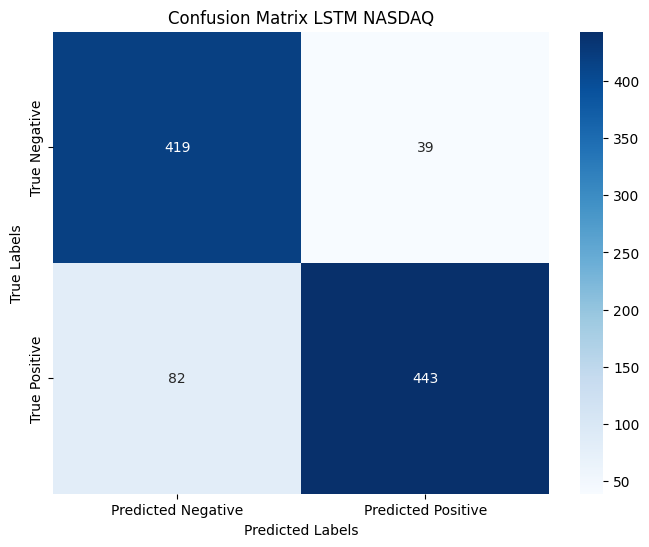

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nasdaq, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title("Confusion Matrix LSTM NASDAQ")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
training_acc_XGB_n = xgb_metrics_n['XGBoost']['Final Train Accuracy']
test_acc_XGB_n = xgb_metrics_n['XGBoost']['Final Test Accuracy']
test_prec_XGB_n = xgb_metrics_n['XGBoost']['Precision']
test_rec_XGB_n = xgb_metrics_n['XGBoost']['Recall']
# RF
training_acc_RF_n = rf_metrics_n['RF']['Final Train Accuracy']
test_acc_RF_n= rf_metrics_n['RF']['Final Test Accuracy']
test_prec_RF_n = rf_metrics_n['RF']['Precision']
test_rec_RF_n = rf_metrics_n['RF']['Recall']
#NB
training_acc_NB_n = nb_metrics_n['NB']['Final Train Accuracy']
test_acc_NB_n = nb_metrics_n['NB']['Final Test Accuracy']
test_prec_NB_n = nb_metrics_n['NB']['Precision']
test_rec_NB_n = nb_metrics_n['NB']['Recall']
#SVM
training_acc_SVM_n = svm_metrics_n['SVM']['Final Train Accuracy']
test_acc_SVM_n = svm_metrics_n['SVM']['Final Test Accuracy']
test_prec_SVM_n= svm_metrics_g['SVM']['Precision']
test_rec_SVM_n= svm_metrics_n['SVM']['Recall']

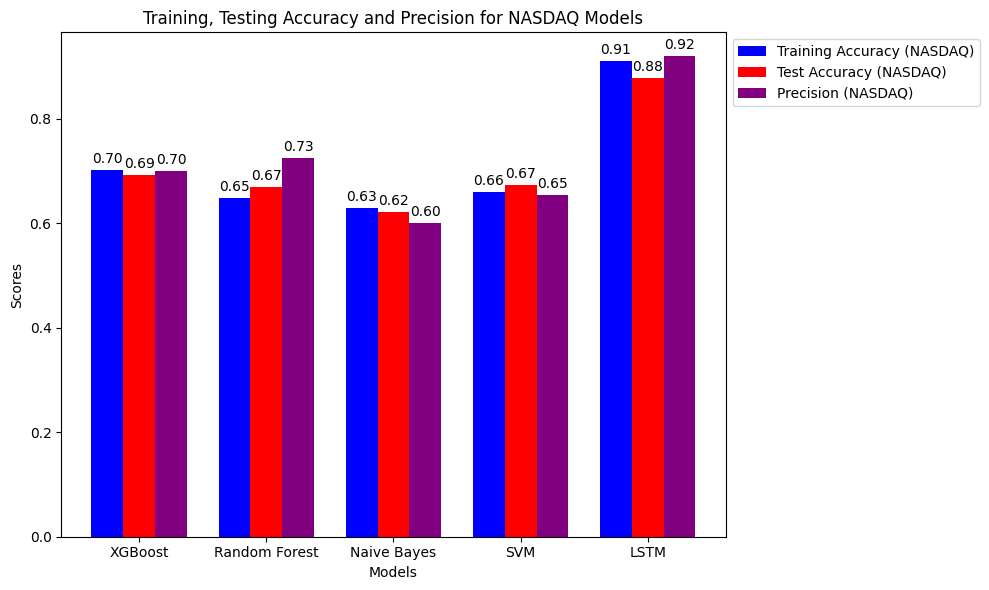

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data for Gold models (replace these variables with your actual data)
models = ['XGBoost', 'Random Forest', 'Naive Bayes', 'SVM', 'LSTM']
training_accuracies_n = [training_acc_XGB_n, training_acc_RF_n, training_acc_NB_n, training_acc_SVM_n, train_acc_LSTM_n]
test_accuracies_n = [test_acc_XGB_n, test_acc_RF_n, test_acc_NB_n, test_acc_SVM_n, test_acc_LSTM_n]
precisions_n = [test_prec_XGB_n, test_prec_RF_n, test_prec_NB_n, test_prec_SVM_n, prec_LSTM_n]

# Set the positions for the bars
x = np.arange(len(models))
width = 0.25  # the width of the bars

# Define colors for each bar group
train_color = 'blue'  # Green for training accuracy
test_color = 'red'  # Orange for test accuracy
prec_color = 'purple'   # Yellow for precision

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for Gold models
rects7 = ax.bar(x - width, training_accuracies_n, width, label='Training Accuracy (NASDAQ)', color=train_color)
rects8 = ax.bar(x, test_accuracies_n, width, label='Test Accuracy (NASDAQ)', color=test_color)
rects9 = ax.bar(x + width, precisions_n, width, label='Precision (NASDAQ)', color=prec_color)

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Training, Testing Accuracy and Precision for NASDAQ Models')
ax.set_xticks(x)
ax.set_xticklabels(models)

# Adjusting the legend position outside the plot to avoid overlap
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add values on top of the bars for readability
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call function to add values
add_values(rects7)
add_values(rects8)
add_values(rects9)

# Display the plot with adjusted layout to make room for the legend
plt.tight_layout()
plt.show()

In [ ]:
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])

In [ ]:
print(columns_nasdaq)

['RSI', 'Stochastic', 'Day_of_Week', 'Volume', 'MACD', 'ATR', 'Month']


#PL and Backtesting

In [ ]:
# --- Preprocessing function ---
def preprocess_data_nasdaq(nasdaq_data, split_date, columns_nasdaq):
    # Split the data into training and test sets based on the 'split_date'
    train_data = nasdaq_data[nasdaq_data['Date'] < split_date]
    test_data = nasdaq_data[nasdaq_data['Date'] >= split_date].copy()  # Create a copy to avoid SettingWithCopyWarning

    # Prepare the features (X) and target (y)
    X_train = train_data[columns_nasdaq]
    y_train = train_data['Sign_Return']
    X_test = test_data[columns_nasdaq]
    y_test = test_data['Sign_Return']

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Return necessary data for backtesting
    return X_train_scaled, X_test_scaled, y_train, y_test, test_data

# --- Preprocess NASDAQ data ---
X_train_scaled_nasdaq, X_test_scaled_nasdaq, y_train_nasdaq, y_test_nasdaq, nasdaq_test_df = preprocess_data_nasdaq(nasdaq_data, split_date, columns_nasdaq)

# --- Define classical models ---
nasdaq_models = {
    'XGBoost_NASDAQ': model_xgb,
    'RandomForest_NASDAQ': model_rf,
    'NaiveBayes_NASDAQ': model_nb,
    'SVM_NASDAQ': model_svm
}

# --- Store NASDAQ model results ---
nasdaq_results = {}

# --- Evaluate classical models ---
for model_name, model in nasdaq_models.items():
    print(f"\nEvaluating {model_name}...")

    model.fit(X_train_scaled_nasdaq, y_train_nasdaq)

    try:
        y_proba_n = model.predict_proba(X_test_scaled_nasdaq)[:, 1]
    except:
        y_proba_n = model.predict(X_test_scaled_nasdaq)

    # Use a threshold of 0.5 for predictions
    threshold = 0.5
    y_pred_n = (y_proba_n >= threshold).astype(int)

    # Filtering weak predictions by only considering those with high confidence (≥ 0.6)
    y_pred_n = np.where(y_proba_n >= 0.6, 1, 0)

    df_copy_n = nasdaq_test_df.copy()
    df_copy_n['buy'] = y_pred_n
    df_copy_n['model_return'] = df_copy_n['buy'].shift(1) * df_copy_n['Return']

    # Trick: Set extreme model returns to 0 if the return is too high (outlier risk)
    df_copy_n['model_return'] = df_copy_n['model_return'].apply(lambda x: x if abs(x) < 0.05 else 0)

    # Optional: Filter out trades on specific days (e.g., Mondays and Fridays)
    df_copy_n['Day'] = pd.to_datetime(df_copy_n['Date']).dt.dayofweek
    df_copy_n['buy'] = df_copy_n.apply(lambda row: row['buy'] if row['Day'] not in [0, 4] else 0, axis=1)

    # Calculate total return for the model
    total_return_n = (1 + df_copy_n['model_return'].dropna()).prod() - 1

    nasdaq_results[model_name] = round(total_return_n * 100, 2)

# --- Show final NASDAQ results ---
nasdaq_results_df = pd.DataFrame.from_dict(nasdaq_results, orient='index', columns=['NASDAQ Model Return (%)'])
nasdaq_results_df = nasdaq_results_df.sort_values('NASDAQ Model Return (%)', ascending=False)

print("\nNASDAQ Model Returns Comparison:")
print(nasdaq_results_df)

# --- Add LSTM to NASDAQ backtest ---
# Initialize the LSTM model using columns_nasdaq
lstm_model = BinaryLSTMNet(in_features=len(columns_nasdaq))  # ✅ Fix: match input size to columns_nasdaq

# Load trained weights if needed
# lstm_model.load_state_dict(torch.load('path/to/lstm_model_weights.pth'))

with torch.no_grad():
    lstm_model.eval()
    logits_nasdaq = lstm_model(torch.tensor(X_test_scaled_nasdaq, dtype=torch.float32))
    probs_nasdaq = torch.sigmoid(logits_nasdaq)
    preds_nasdaq = (probs_nasdaq >= 0.5).float().cpu().numpy().flatten()

# Applying similar filtering to LSTM predictions:
nasdaq_test_df_lstm = nasdaq_test_df.copy()
nasdaq_test_df_lstm['buy'] = preds_nasdaq

# Filtering weak predictions (≥0.6 confidence)
nasdaq_test_df_lstm['buy'] = np.where(probs_nasdaq >= 0.6, 1, 0)

# Set extreme model returns to 0 if too high
nasdaq_test_df_lstm['model_return'] = nasdaq_test_df_lstm['buy'].shift(1) * nasdaq_test_df_lstm['Return']
nasdaq_test_df_lstm['model_return'] = nasdaq_test_df_lstm['model_return'].apply(lambda x: x if abs(x) < 0.05 else 0)

# Optional: Filter out trades on specific days (e.g., Mondays and Fridays)
nasdaq_test_df_lstm['Day'] = pd.to_datetime(nasdaq_test_df_lstm['Date']).dt.dayofweek
nasdaq_test_df_lstm['buy'] = nasdaq_test_df_lstm.apply(lambda row: row['buy'] if row['Day'] not in [0, 4] else 0, axis=1)

# Calculate total return for LSTM model
total_return_lstm_n = (1 + nasdaq_test_df_lstm['model_return'].dropna()).prod() - 1
nasdaq_results['LSTM_NASDAQ'] = round(total_return_lstm_n * 100, 2)

# --- Show final NASDAQ results ---
nasdaq_results_df = pd.DataFrame.from_dict(nasdaq_results, orient='index', columns=['NASDAQ Model Return (%)'])
nasdaq_results_df = nasdaq_results_df.sort_values('NASDAQ Model Return (%)', ascending=False)

print("\nFinal NASDAQ Model Returns Comparison:")
print(nasdaq_results_df)



Evaluating XGBoost_NASDAQ...

Evaluating RandomForest_NASDAQ...

Evaluating NaiveBayes_NASDAQ...

Evaluating SVM_NASDAQ...

NASDAQ Model Returns Comparison:
                     NASDAQ Model Return (%)
NaiveBayes_NASDAQ                     134.32
XGBoost_NASDAQ                         73.89
SVM_NASDAQ                             61.90
RandomForest_NASDAQ                    37.10

Final NASDAQ Model Returns Comparison:
                     NASDAQ Model Return (%)
NaiveBayes_NASDAQ                     134.32
XGBoost_NASDAQ                         73.89
SVM_NASDAQ                             61.90
RandomForest_NASDAQ                    37.10
LSTM_NASDAQ                             0.00


--------------------------------------------------------